##Installing requirements and libraries

In [ ]:
print('Installing Requirements... ',end='')
%pip install lightning
%pip install wandb
%pip install torchaudio
print('Done')

Installing Requirements... Collecting lightning
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.0 MB/s eta 0:00:00
Done


In [ ]:
print('Importing Libraries... ',end='')

import os
from pathlib import Path
import pandas as pd
import torchaudio
import zipfile
from torchaudio.transforms import Resample
import IPython.display as ipd
from matplotlib import pyplot as plt
from tqdm import tqdm
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import copy
from torch.nn.utils import clip_grad_norm_
print('Done')

Importing Libraries... Done


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

##Setting up the dataset

In [ ]:
folder_path = '/content/drive/MyDrive/Deep Learning/Assignment 2/Archive (6)'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
files = os.listdir(folder_path)
print("Files and directories in '", folder_path, "' :")
print(files)

Files and directories in ' /content/drive/MyDrive/Deep Learning/Assignment 2/Archive (6) ' :
['.DS_Store', 'meta', 'audio']


In [ ]:
meta_file_path = '/content/drive/MyDrive/Deep Learning/Assignment 2/Archive (6)/meta/esc50.csv'
path = Path('/content/drive/MyDrive/Deep Learning/Assignment 2/Archive (6)')
df = pd.read_csv(meta_file_path)
print(df.head())

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


Shape of waveform: torch.Size([1, 220500])
Sample rate of waveform: 44100


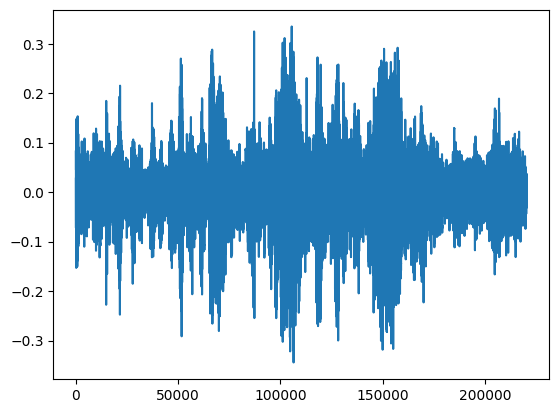

In [ ]:
wavs = list(path.glob('audio/*'))
waveform, sample_rate = torchaudio.load(str(wavs[0]))

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.figure()
plt.plot(waveform.t().numpy())

ipd.Audio(waveform, rate=sample_rate)


In [ ]:

def save_model(epoch, model, optimizer, file_path="model_checkpoint.pth"):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, file_path)


In [ ]:
def load_model(model, optimizer, file_path=None):
    if file_path is None:
        file_path = "model_checkpoint.pth"
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return epoch, model, optimizer

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataset, **kwargs):
        self.data_directory = kwargs["data_directory"]
        self.data_frame = kwargs["data_frame"]
        self.validation_fold = kwargs["validation_fold"]
        self.testing_fold = kwargs["testing_fold"]
        self.esc_10_flag = kwargs["esc_10_flag"]
        self.file_column = kwargs["file_column"]
        self.label_column = kwargs["label_column"]
        self.sampling_rate = kwargs["sampling_rate"]
        self.new_sampling_rate = kwargs["new_sampling_rate"]
        self.sample_length_seconds = kwargs["sample_length_seconds"]

        if self.esc_10_flag:
            self.data_frame = self.data_frame.loc[self.data_frame['esc10'] == True]

        if dataset == "train":
            self.data_frame = self.data_frame.loc[
                (self.data_frame['fold'] != self.validation_fold) & (self.data_frame['fold'] != self.testing_fold)]
        elif dataset == "val":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.validation_fold]
        elif dataset == "test":
            self.data_frame = self.data_frame.loc[self.data_frame['fold'] == self.testing_fold]

        self.categories = sorted(self.data_frame[self.label_column].unique())

        self.file_names = []
        self.labels = []

        self.category_to_index = {}
        self.index_to_category = {}

        for i, category in enumerate(self.categories):
            self.category_to_index[category] = i
            self.index_to_category[i] = category

        for ind in tqdm(range(len(self.data_frame))):
            row = self.data_frame.iloc[ind]
            file_path = self.data_directory / "audio" / row[self.file_column]
            self.file_names.append(file_path)
            self.labels.append(self.category_to_index[row[self.label_column]])

        self.resampler = torchaudio.transforms.Resample(self.sampling_rate, self.new_sampling_rate)

        if self.sample_length_seconds == 2:
            self.window_size = self.new_sampling_rate * 2
            self.step_size = int(self.new_sampling_rate * 0.75)
        else:
            self.window_size = self.new_sampling_rate
            self.step_size = int(self.new_sampling_rate * 0.5)

    def __getitem__(self, index):
        path = self.file_names[index]
        audio_file = torchaudio.load(str(path), format=None, normalize=True)
        audio_tensor = self.resampler(audio_file[0])
        splits = audio_tensor.unfold(1, self.window_size, self.step_size)
        samples = splits.permute(1, 0, 2)
        return samples, self.labels[index]

    def __len__(self):
        return len(self.file_names)


In [ ]:
class CustomDataModule(pl.LightningDataModule):
    def __init__(self, **kwargs):
        super().__init__()
        self.batch_size = kwargs["batch_size"]
        self.num_workers = kwargs["num_workers"]
        self.data_module_kwargs = kwargs

    def setup(self, stage=None, current_fold=None):
        kwargs = dict(self.data_module_kwargs)
        kwargs.pop('validation_fold', None)
        kwargs.pop('testing_fold', None)
        test_fold = kwargs.get('testing_fold', 1)

        if stage in {'fit', None}:
            self.training_dataset = CustomDataset(dataset="train", validation_fold=current_fold, testing_fold=test_fold, **kwargs)
            self.validation_dataset = CustomDataset(dataset="val", validation_fold=current_fold, testing_fold=test_fold, **kwargs)

        if stage in {'test', None}:
            self.testing_dataset = CustomDataset(dataset="test", validation_fold=current_fold, testing_fold=test_fold, **kwargs)


    def train_dataloader(self):
        return DataLoader(self.training_dataset,
                          batch_size=self.batch_size,
                          shuffle=True,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.validation_dataset,
                          batch_size=self.batch_size,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.testing_dataset,
                          batch_size=32,
                          shuffle=False,
                          collate_fn=self.collate_function,
                          num_workers=self.num_workers)

    def collate_function(self, batch):
     """
     Collate function to process a batch of examples and labels.

     Args:
        batch: a list of tuples (example, label), where
            example is a tensor of split 1-second sub-frame audio tensors per file,
            label is the label for the entire file.

     Returns:
         A tuple containing batches of examples and labels.
     """
     example_tensors = []
     label_tensors = []

     for single_example, single_label in batch:
       for each_subframe in single_example:
         example_tensors.append(each_subframe)
         label_tensors.append(single_label)

     stacked_examples = torch.stack(example_tensors)
     encoded_labels = torch.tensor(label_tensors, dtype=torch.long)

     return stacked_examples, encoded_labels



###Train Test Validate Functions

In [ ]:
#Training with gradient clipping(used for transformers architecture)
def train_one_epoch(model, train_loader, criterion, optimizer, device, max_norm=2.0):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        clip_grad_norm_(model.parameters(), max_norm=max_norm)

        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [ ]:
#Used for CNN architecture
def trains_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss, total_correct, total_samples = 0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    return total_loss / len(train_loader), 100 * total_correct / total_samples

In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss, total_correct, total_samples = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    return total_loss / len(val_loader), 100 * total_correct / total_samples

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #plt.close()

In [ ]:
def test_model(model, test_loader, criterion, device, num_classes):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(probs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probs.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct_predictions / total_predictions
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    all_labels_binarized = label_binarize(all_labels, classes=range(num_classes))
    roc_auc = roc_auc_score(all_labels_binarized, all_probabilities, multi_class='ovr', average='macro')

    plot_confusion_matrix(conf_matrix, classes=range(num_classes), title='Confusion Matrix')
    wandb.log({"Confusion Matrix": wandb.Image(plt)})

    fpr, tpr, roc_auc_dict = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels_binarized[:, i], np.array(all_probabilities)[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    colors = cycle(['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'cyan', 'magenta', 'lime', 'gray'])
    plt.figure()
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc_dict[i]:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (Multi-Class)')
    plt.legend(loc="lower right")
    wandb.log({"ROC Curve": wandb.Image(plt)})
    plt.close()

    return avg_loss, accuracy, f1, roc_auc

##Architecture : 1

In [ ]:
class SoundClassifier(nn.Module):
    def __init__(self, output_size, sequence_length):
        super(SoundClassifier, self).__init__()

        self.conv_layer1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)


        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)


        feature_dim = sequence_length //(2**3)  # 3 pooling layers that halve the input size each time

        self.dense_layer1 = nn.Linear(64 * feature_dim, 128)
        self.dense_layer2 = nn.Linear(128, output_size)

    def forward(self, input_tensor):
        input_tensor = self.max_pool(F.relu(self.conv_layer1(input_tensor)))
        input_tensor = self.max_pool(F.relu(self.conv_layer2(input_tensor)))
        input_tensor = self.max_pool(F.relu(self.conv_layer3(input_tensor)))

        input_tensor = input_tensor.view(input_tensor.size(0), -1)

        input_tensor = F.relu(self.dense_layer1(input_tensor))
        output_tensor = self.dense_layer2(input_tensor)

        return output_tensor


###Hyperparameter Tuning

####Before using dropout, early stopping and regularization

100%|██████████| 80/80 [00:00<00:00, 14928.34it/s]


Fold 2, Epoch [1/100] - Training Loss: 3.0815, Accuracy: 9.17%
Validation Loss: 2.3459, Accuracy: 10.00%

Fold 2, Epoch [10/100] - Training Loss: 1.7745, Accuracy: 36.53%
Validation Loss: 1.9502, Accuracy: 27.08%

Fold 2, Epoch [20/100] - Training Loss: 1.1785, Accuracy: 55.32%
Validation Loss: 1.6951, Accuracy: 34.44%

Fold 2, Epoch [30/100] - Training Loss: 0.6463, Accuracy: 76.67%
Validation Loss: 2.0043, Accuracy: 38.19%

Fold 2, Epoch [40/100] - Training Loss: 0.5354, Accuracy: 82.45%
Validation Loss: 2.5566, Accuracy: 39.03%

Fold 2, Epoch [50/100] - Training Loss: 0.7831, Accuracy: 74.72%
Validation Loss: 3.3682, Accuracy: 31.53%

Fold 2, Epoch [60/100] - Training Loss: 0.4697, Accuracy: 84.26%
Validation Loss: 2.7561, Accuracy: 40.56%

Fold 2, Epoch [70/100] - Training Loss: 0.3818, Accuracy: 86.48%
Validation Loss: 3.4183, Accuracy: 42.92%

Fold 2, Epoch [80/100] - Training Loss: 0.3262, Accuracy: 87.96%
Validation Loss: 4.0326, Accuracy: 38.47%

Fold 2, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▃▃▄▄▅▆▆▆▇▇▇▇▇▇▇█▇▇▇██▇██████████████▇
train_loss,█▆▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆
val_accuracy,▁▁▃▄▆▅▅▅▆▅▆▆▇▇▇▇▇█▇▆▅▇█▆▇▇██▆▇▇▇▇▇█▇▇▇▇▄
val_loss,▂▂▂▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅█
test_accuracy,30.41667
test_f1,0.26035
test_loss,7.76584


100%|██████████| 80/80 [00:00<00:00, 15609.62it/s]


Fold 3, Epoch [1/100] - Training Loss: 3.6141, Accuracy: 9.72%
Validation Loss: 2.3400, Accuracy: 10.28%

Fold 3, Epoch [10/100] - Training Loss: 1.5366, Accuracy: 47.04%
Validation Loss: 1.9433, Accuracy: 31.11%

Fold 3, Epoch [20/100] - Training Loss: 0.7937, Accuracy: 71.53%
Validation Loss: 1.7963, Accuracy: 43.75%

Fold 3, Epoch [30/100] - Training Loss: 0.5251, Accuracy: 80.37%
Validation Loss: 2.5010, Accuracy: 38.47%

Fold 3, Epoch [40/100] - Training Loss: 0.5339, Accuracy: 80.93%
Validation Loss: 3.1746, Accuracy: 39.17%

Fold 3, Epoch [50/100] - Training Loss: 0.3623, Accuracy: 86.81%
Validation Loss: 3.4026, Accuracy: 46.94%

Fold 3, Epoch [60/100] - Training Loss: 0.3238, Accuracy: 89.03%
Validation Loss: 4.2031, Accuracy: 45.69%

Fold 3, Epoch [70/100] - Training Loss: 0.2910, Accuracy: 89.63%
Validation Loss: 5.2599, Accuracy: 43.47%

Fold 3, Epoch [80/100] - Training Loss: 0.3114, Accuracy: 87.64%
Validation Loss: 5.2408, Accuracy: 41.67%

Fold 3, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▂▃▃▄▅▆▆▆▇▇▇▇▇▇▇▇▇▇██▇▇█████▇███████████
train_loss,█▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▅▅▆▇▇▇▇▆▇▇▆▇▇▇████▇██████▅▇▇▇▇█▇█▇▇▇▇
val_loss,▂▁▁▁▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅█▆▅▅▅▅▅▆▅▆▆▆
test_accuracy,42.08333
test_f1,0.40364
test_loss,4.41107


100%|██████████| 80/80 [00:00<00:00, 15176.82it/s]


Fold 4, Epoch [1/100] - Training Loss: 3.1367, Accuracy: 7.92%
Validation Loss: 2.3360, Accuracy: 10.00%

Fold 4, Epoch [10/100] - Training Loss: 1.9067, Accuracy: 25.97%
Validation Loss: 2.0820, Accuracy: 16.81%

Fold 4, Epoch [20/100] - Training Loss: 1.3569, Accuracy: 50.19%
Validation Loss: 1.6775, Accuracy: 40.00%

Fold 4, Epoch [30/100] - Training Loss: 0.9075, Accuracy: 67.50%
Validation Loss: 1.6122, Accuracy: 44.17%

Fold 4, Epoch [40/100] - Training Loss: 0.6523, Accuracy: 77.45%
Validation Loss: 1.7957, Accuracy: 48.33%

Fold 4, Epoch [50/100] - Training Loss: 0.5289, Accuracy: 82.64%
Validation Loss: 2.6796, Accuracy: 41.81%

Fold 4, Epoch [60/100] - Training Loss: 0.4862, Accuracy: 84.91%
Validation Loss: 2.6023, Accuracy: 41.39%

Fold 4, Epoch [70/100] - Training Loss: 0.3998, Accuracy: 86.30%
Validation Loss: 3.0631, Accuracy: 40.56%

Fold 4, Epoch [80/100] - Training Loss: 0.3166, Accuracy: 89.35%
Validation Loss: 3.4073, Accuracy: 42.50%

Fold 4, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████████████
train_loss,█▆▆▅▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▅▅▇▇▇▇▇▇▇▇▇▇▇▇▇██▆███▆█▇▇█▇▇▇▇▆▇▇▇▇▇
val_loss,▃▃▃▂▂▂▁▁▁▁▁▁▂▁▁▂▂▂▃▄▃▅▂▃▄▆▅▅▅▇▅▆▆▆▇▇▇▇██
test_accuracy,40.55556
test_f1,0.40974
test_loss,4.19732


100%|██████████| 80/80 [00:00<00:00, 16094.80it/s]


Fold 5, Epoch [1/100] - Training Loss: 3.6517, Accuracy: 8.33%
Validation Loss: 2.4158, Accuracy: 10.00%

Fold 5, Epoch [10/100] - Training Loss: 1.9712, Accuracy: 26.34%
Validation Loss: 2.2698, Accuracy: 31.25%

Fold 5, Epoch [20/100] - Training Loss: 1.0994, Accuracy: 60.51%
Validation Loss: 1.9185, Accuracy: 48.19%

Fold 5, Epoch [30/100] - Training Loss: 0.8358, Accuracy: 69.63%
Validation Loss: 3.4739, Accuracy: 33.19%

Fold 5, Epoch [40/100] - Training Loss: 0.7609, Accuracy: 75.42%
Validation Loss: 3.2387, Accuracy: 40.00%

Fold 5, Epoch [50/100] - Training Loss: 0.4924, Accuracy: 84.63%
Validation Loss: 2.8523, Accuracy: 49.86%

Fold 5, Epoch [60/100] - Training Loss: 0.4308, Accuracy: 84.86%
Validation Loss: 3.6237, Accuracy: 48.47%

Fold 5, Epoch [70/100] - Training Loss: 0.3829, Accuracy: 86.25%
Validation Loss: 4.5759, Accuracy: 45.42%

Fold 5, Epoch [80/100] - Training Loss: 0.3852, Accuracy: 87.45%
Validation Loss: 4.2700, Accuracy: 45.83%

Fold 5, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▁▂▃▄▄▅▆▅▆▆▆▇▇▆▇▇▇▇▇▇██████████████████
train_loss,█▅▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▄▃▄▆▇▇▅▇▇▇▇▆▇▆▇▇██▇█▇▇▇█▆▇▇█▇▇▆▇▇▇▇▇▇█
val_loss,▂▂▂▂▂▂▁▁▂▃▂▂▃▃▃▄▃▂▂▃▄▃▅▅▄▅▆▅▆▆▆▇▆███▇▆▇▇
test_accuracy,45.69444
test_f1,0.44163
test_loss,4.47767


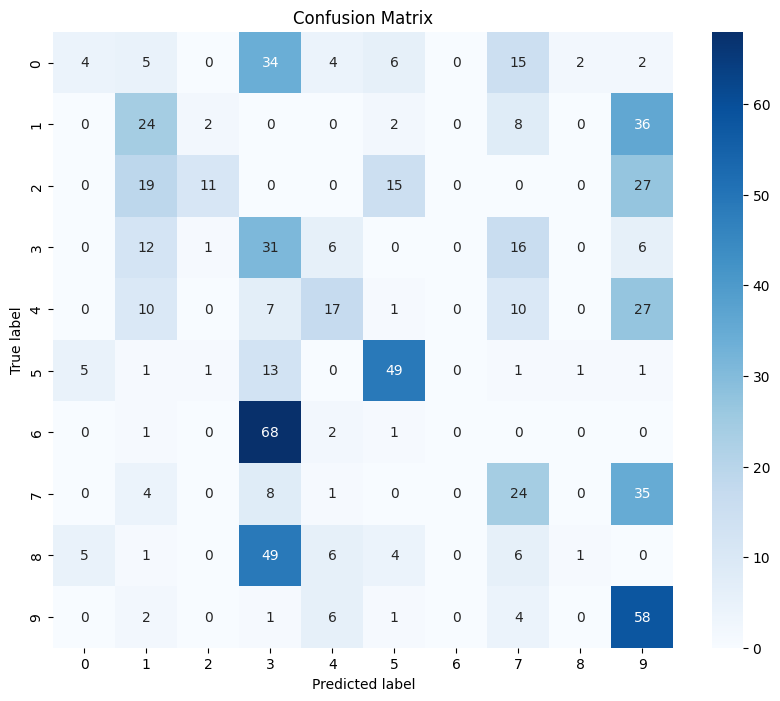

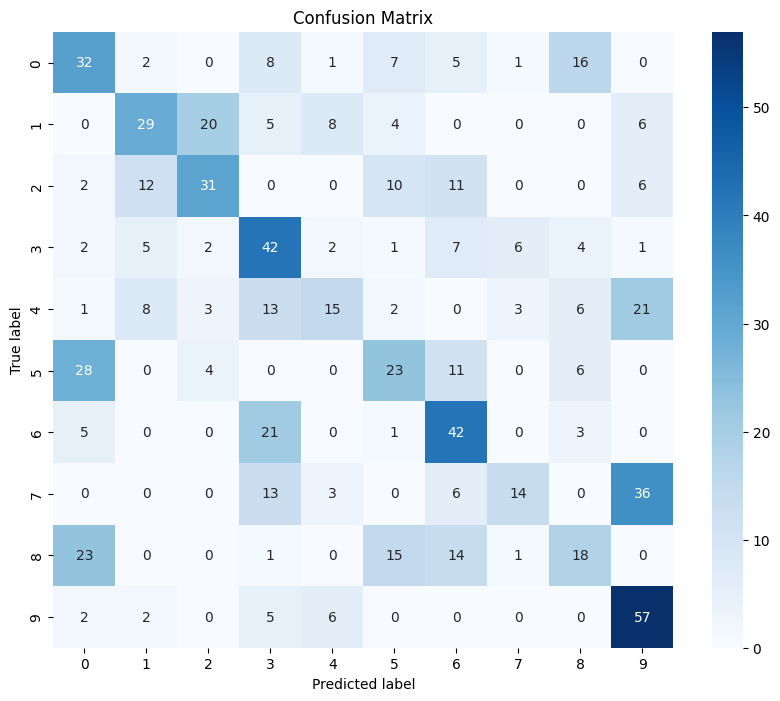

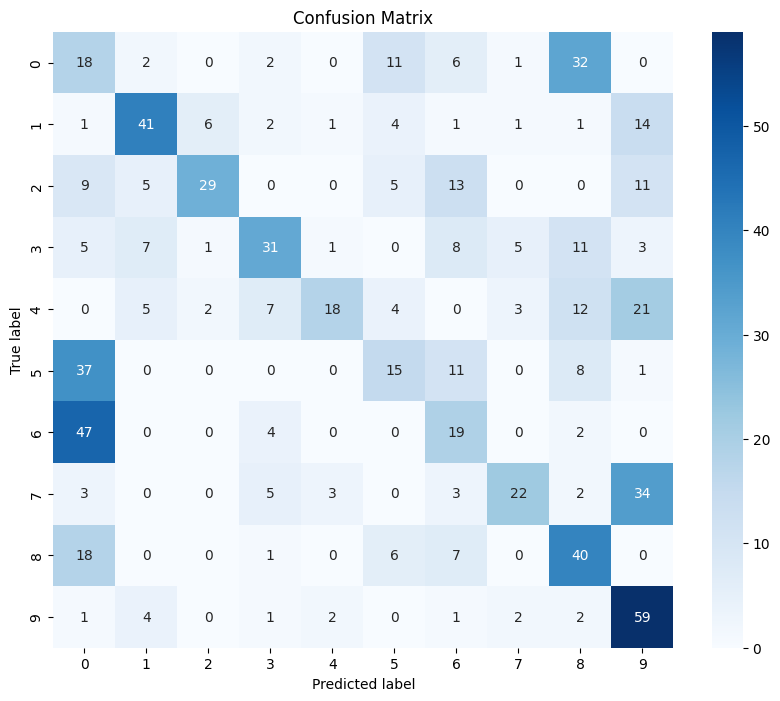

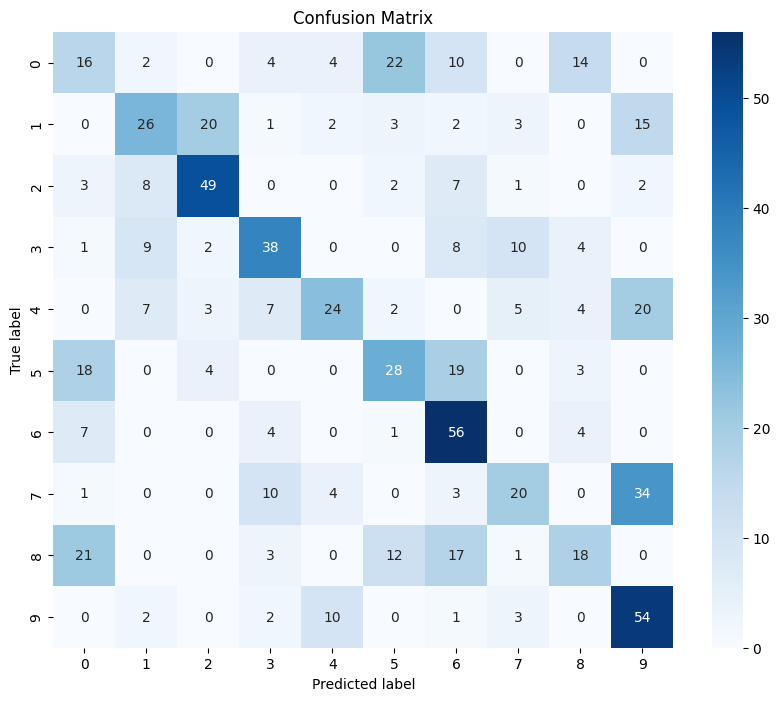

In [ ]:
from itertools import cycle

import wandb
wandb.login()

config = {
    'num_epochs': 100,
    'k_folds': 5,
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'input_length': 16000,
    'num_workers':2
}

for fold in range(1, config['k_folds'] + 1):
    if fold == 1:
       continue

    wandb.init(project='audio_classification_assn2', entity='m23csa001',config=config, name=f'CNN Fold {fold}', reinit=True)

    data_module = CustomDataModule(batch_size=config['batch_size'],
                                   num_workers=config['num_workers'],
                                   data_directory=path,
                                   data_frame=df,
                                   validation_fold=fold,
                                   testing_fold=1,
                                   esc_10_flag=True,
                                   file_column='filename',
                                   label_column='category',
                                   sampling_rate=44100,
                                   new_sampling_rate=16000,
                                   sample_length_seconds=1
                                   )

    data_module.setup(stage='fit', current_fold=fold)
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    data_module.setup(stage='test', current_fold=1)
    test_loader = data_module.test_dataloader()

    model_1 = SoundClassifier(sequence_length=config['input_length'],output_size=config['num_classes']).to(config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_1.parameters(), lr=config['learning_rate'])

    for epoch in range(config['num_epochs']):
        train_loss, train_accuracy = trains_one_epoch(model_1, train_loader, criterion, optimizer, config['device'])
        val_loss, val_accuracy = validate_one_epoch(model_1, val_loader, criterion, config['device'])
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == config["num_epochs"]:
           print(f'Fold {fold}, Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
           print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')

    test_loss, test_accuracy, test_f1, test_roc_auc = test_model(model_1, test_loader, criterion, config['device'], config['num_classes'])
    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, ROC AUC: {test_roc_auc:.2f}')
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1': test_f1, 'test_roc_auc': test_roc_auc})

    wandb.finish()


In [ ]:
total_params = sum(p.numel() for p in model_1.parameters())
trainable_params = sum(p.numel() for p in model_1.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

total_params, trainable_params, non_trainable_params

(16393258, 16393258, 0)

####After using dropout, early stopping and regularization

In [ ]:
class SoundClassifierupdated(nn.Module):
    def __init__(self, output_size, sequence_length):
        super(SoundClassifierupdated, self).__init__()

        self.conv_layer1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv_layer2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_layer3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.max_pool = nn.MaxPool1d(kernel_size=2, stride=2)
        feature_dim = sequence_length // 8

        self.dense_layer1 = nn.Linear(64 * feature_dim, 128)
        self.dense_layer2 = nn.Linear(128, output_size)

        self.layer_dropout = nn.Dropout(p=0.5)

    def forward(self, input_tensor):
        input_tensor = self.max_pool(F.relu(self.conv_layer1(input_tensor)))
        input_tensor = self.max_pool(F.relu(self.conv_layer2(input_tensor)))
        input_tensor = self.max_pool(F.relu(self.conv_layer3(input_tensor)))

        input_tensor = input_tensor.view(input_tensor.size(0), -1)

        input_tensor = F.relu(self.dense_layer1(input_tensor))
        input_tensor = self.layer_dropout(input_tensor)
        output_tensor = self.dense_layer2(input_tensor)

        return output_tensor


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_accuracy,▁▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇██████████
train_loss,█▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▃▃▄▄▄▅▅▅▅▅▆▅▆▆▅▆▆█▇▇▇▇█▇▇█▇▇▇▇▇█▇▇▇▇▆
val_loss,███▇▇▆▆▅▄▄▄▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▂▃▁▃▄▄▃▃▃▃▆▅▆▅
train_accuracy,59.62963
train_loss,0.98953
val_accuracy,32.91667
val_loss,2.02408


100%|██████████| 80/80 [00:00<00:00, 9769.53it/s]


Fold 2, Epoch [1/100] - Training Loss: 2.7753, Accuracy: 9.12%
Validation Loss: 2.3085, Accuracy: 10.69%

Fold 2, Epoch [10/100] - Training Loss: 2.0547, Accuracy: 25.93%
Validation Loss: 2.0612, Accuracy: 25.28%

Fold 2, Epoch [20/100] - Training Loss: 1.6161, Accuracy: 39.72%
Validation Loss: 1.7839, Accuracy: 30.97%

Fold 2, Epoch [30/100] - Training Loss: 1.2765, Accuracy: 51.90%
Validation Loss: 1.6673, Accuracy: 40.83%

Fold 2, Epoch [40/100] - Training Loss: 1.0295, Accuracy: 62.22%
Validation Loss: 1.7199, Accuracy: 44.72%

Fold 2, Epoch [50/100] - Training Loss: 0.8907, Accuracy: 68.24%
Validation Loss: 1.8929, Accuracy: 47.92%

Early stopping on fold 2, epoch 53
Fold 2, Test Loss: 1.5196, Test Accuracy: 48.47%, F1 Score: 0.47, ROC AUC: 0.88


test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████
train_loss,█▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▂▄▃▄▃▄▅▅▅▅▅▅▆▅▅▅▇▆▇▆█▆▇▆▇▇▇▇▇▇▇▇▇█▇█
val_loss,███▇▇▇▆▆▆▄▄▄▅▃▃▂▂▂▂▄▂▂▂▃▁▃▂▂▂▃▃▃▂▃▄▄▃▄▄▃
test_accuracy,48.47222
test_f1,0.47152
test_loss,1.51958


100%|██████████| 80/80 [00:00<00:00, 15945.65it/s]


Fold 3, Epoch [1/100] - Training Loss: 3.3717, Accuracy: 7.69%
Validation Loss: 2.3331, Accuracy: 10.00%

Fold 3, Epoch [10/100] - Training Loss: 2.1775, Accuracy: 16.85%
Validation Loss: 2.1024, Accuracy: 23.33%

Fold 3, Epoch [20/100] - Training Loss: 1.7421, Accuracy: 32.22%
Validation Loss: 1.8708, Accuracy: 30.00%

Fold 3, Epoch [30/100] - Training Loss: 1.4133, Accuracy: 44.81%
Validation Loss: 1.6597, Accuracy: 36.39%

Fold 3, Epoch [40/100] - Training Loss: 1.1575, Accuracy: 53.19%
Validation Loss: 1.8140, Accuracy: 38.61%

Early stopping on fold 3, epoch 49
Fold 3, Test Loss: 1.4217, Test Accuracy: 45.97%, F1 Score: 0.45, ROC AUC: 0.88


test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▅▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇█▇█████
train_loss,█▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▁▃▃▁▂▄▄▄▄▅▅▅▅▅▇▆▇▆▆▇▇▇▇▆▇▆▇▇▆▇▇█▇█▇▇▇
val_loss,███▇▇▆▇▇▆▄▃▃▃▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▃▂▃▂▃▂▂▃▃▃▃▄
test_accuracy,45.97222
test_f1,0.45485
test_loss,1.42171


100%|██████████| 80/80 [00:00<00:00, 13613.45it/s]


Fold 4, Epoch [1/100] - Training Loss: 2.5994, Accuracy: 8.89%
Validation Loss: 2.3070, Accuracy: 10.00%

Fold 4, Epoch [10/100] - Training Loss: 1.9790, Accuracy: 24.21%
Validation Loss: 1.9430, Accuracy: 32.78%

Fold 4, Epoch [20/100] - Training Loss: 1.4449, Accuracy: 46.39%
Validation Loss: 1.5800, Accuracy: 39.03%

Fold 4, Epoch [30/100] - Training Loss: 1.0186, Accuracy: 60.69%
Validation Loss: 1.6272, Accuracy: 41.53%

Fold 4, Epoch [40/100] - Training Loss: 0.8485, Accuracy: 69.49%
Validation Loss: 1.9129, Accuracy: 38.89%

Early stopping on fold 4, epoch 47
Fold 4, Test Loss: 1.5789, Test Accuracy: 43.47%, F1 Score: 0.42, ROC AUC: 0.87


test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▆▆▅▅▆▆▇▆▇▇▇▇▇▇▇▇███████
train_loss,█▇▇▇▇▇▆▆▆▅▅▅▄▄▄▄▄▃▃▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▂▃▃▂▄▆▅▇▅▆▇▇▆▇▇▆▇█▇▇▇▇▇█▇▇▇▇▇▆▇▅▇█▇▇█
val_loss,████▇▇▇▆▅▄▃▄▂▂▁▂▂▁▂▂▁▂▁▁▁▂▁▂▂▂▃▃▆▄▅▄▅▄▆▆
test_accuracy,43.47222
test_f1,0.42001
test_loss,1.57888


100%|██████████| 80/80 [00:00<00:00, 15735.52it/s]


Fold 5, Epoch [1/100] - Training Loss: 2.8337, Accuracy: 10.05%
Validation Loss: 2.3057, Accuracy: 10.00%

Fold 5, Epoch [10/100] - Training Loss: 2.0058, Accuracy: 22.22%
Validation Loss: 1.9663, Accuracy: 32.08%

Fold 5, Epoch [20/100] - Training Loss: 1.7272, Accuracy: 33.52%
Validation Loss: 1.7010, Accuracy: 45.56%

Fold 5, Epoch [30/100] - Training Loss: 1.3417, Accuracy: 49.26%
Validation Loss: 1.6645, Accuracy: 47.36%

Fold 5, Epoch [40/100] - Training Loss: 1.1244, Accuracy: 55.79%
Validation Loss: 2.0063, Accuracy: 41.25%

Early stopping on fold 5, epoch 44
Fold 5, Test Loss: 1.5499, Test Accuracy: 42.92%, F1 Score: 0.39, ROC AUC: 0.86


test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▄▅▆▅▆▆▆▆▇▇▇▆▇▇▇█▇█▇███
train_loss,█▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▂▃▃▃▅▅▅▅▆▆▆▅▆▆▇▇▆▆▇▇▇▇█▇▇▆▇▇█▇▆▇▆██▇
val_loss,██▇▇▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▁▁▂▂▁▂▁▂▁▅▄▄▃▂▄▂▅▃▄▅
test_accuracy,42.91667
test_f1,0.39338
test_loss,1.5499


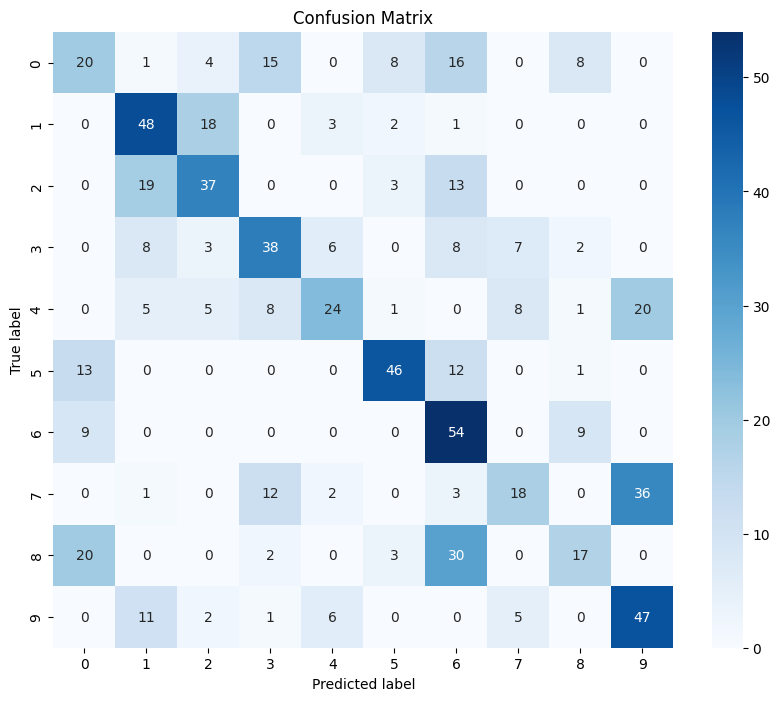

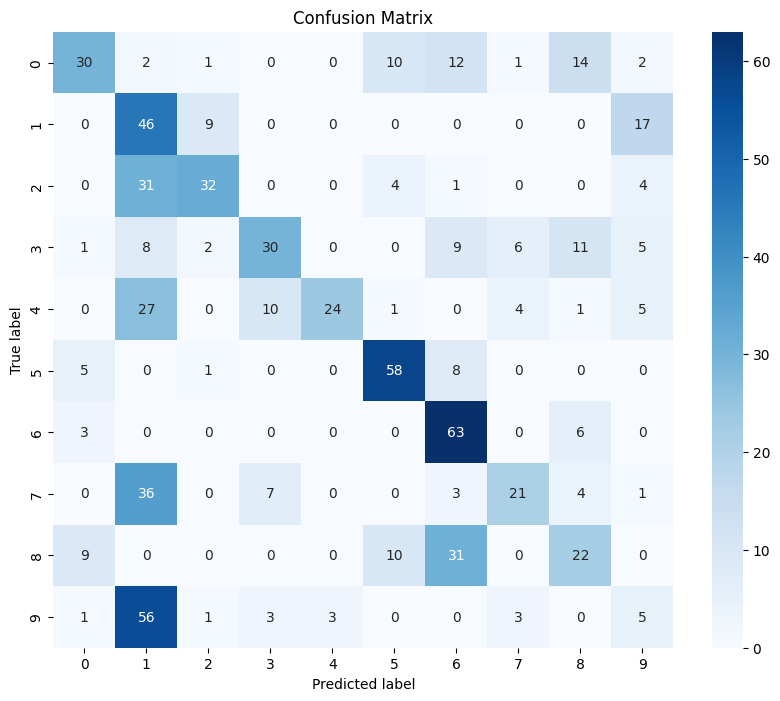

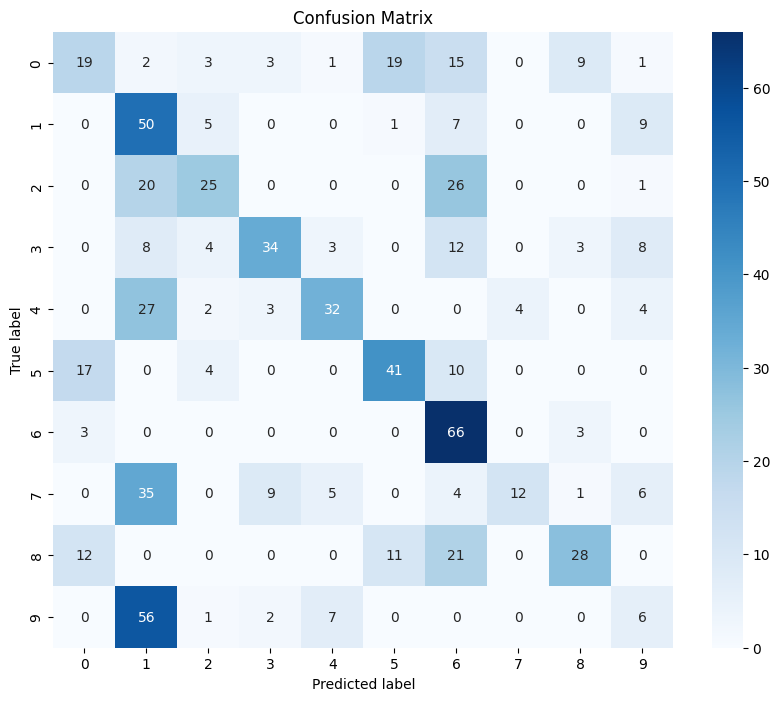

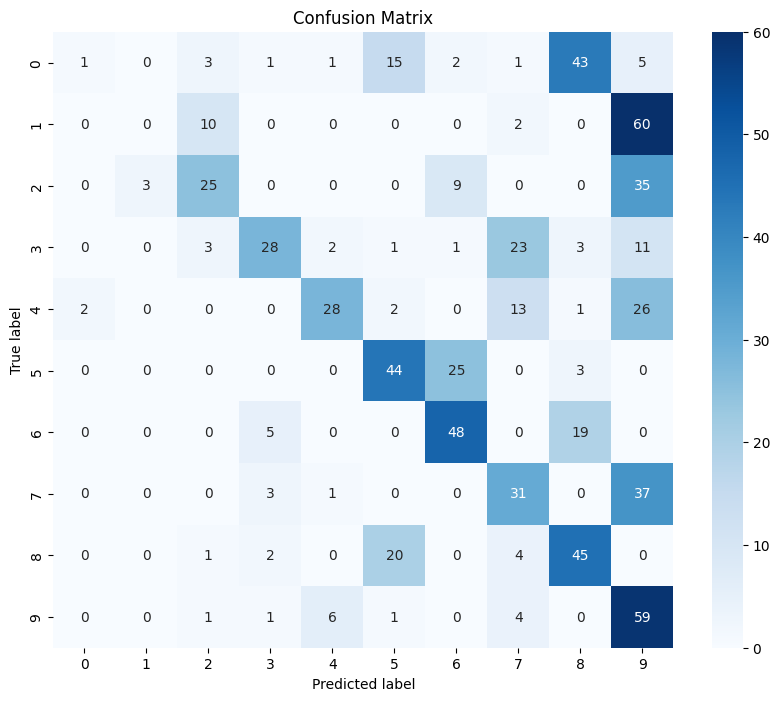

In [ ]:
from itertools import cycle
import wandb

wandb.login()

config = {
    'num_epochs': 100,
    'k_folds': 5,
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'input_length': 16000,
    'num_workers': 2
}

patience = 20

for fold in range(1, config['k_folds'] + 1):
    if fold == 1:
        continue

    wandb.init(project='audio_classification_assn2', entity='m23csa001', config=config, name=f'CNN(Dr,ES,Re) Fold {fold}', reinit=True)

    data_module = CustomDataModule(batch_size=config['batch_size'],
                                   num_workers=config['num_workers'],
                                   data_directory=path,
                                   data_frame=df,
                                   validation_fold=fold,
                                   testing_fold=1,
                                   esc_10_flag=True,
                                   file_column='filename',
                                   label_column='category',
                                   sampling_rate=44100,
                                   new_sampling_rate=16000,
                                   sample_length_seconds=1
                                   )

    data_module.setup(stage='fit', current_fold=fold)
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    data_module.setup(stage='test', current_fold=1)
    test_loader = data_module.test_dataloader()

    model_2 = SoundClassifierupdated(sequence_length=config['input_length'], output_size=config['num_classes']).to(config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_2.parameters(), lr=config['learning_rate'])

    best_val_loss = float('inf')
    wait = 0
    best_model_wts = None

    for epoch in range(config['num_epochs']):
        train_loss, train_accuracy = trains_one_epoch(model_2, train_loader, criterion, optimizer, config['device'])
        val_loss, val_accuracy = validate_one_epoch(model_2, val_loader, criterion, config['device'])
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            wait = 0
            best_model_wts = copy.deepcopy(model_2.state_dict())
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping on fold {fold}, epoch {epoch+1}")
                break

        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == config["num_epochs"]:
            print(f'Fold {fold}, Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')

    if best_model_wts:
        model_2.load_state_dict(best_model_wts)

    test_loss, test_accuracy, test_f1, test_roc_auc = test_model(model_2, test_loader, criterion, config['device'], config['num_classes'])
    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, ROC AUC: {test_roc_auc:.2f}')
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1': test_f1, 'test_roc_auc': test_roc_auc})

    wandb.finish()


##Architecture 2

In [ ]:
class AudioFeatureExtractor(nn.Module):
    def __init__(self, input_channels=1, sequence_length=16000):
        super(AudioFeatureExtractor, self).__init__()

        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        ])
        self.pooling_layer = nn.MaxPool1d(kernel_size=2, stride=2)

        self.feature_dim = self.calculate_feature_dim(sequence_length)

    def calculate_feature_dim(self, length):
       with torch.no_grad():
         sample_input = torch.autograd.Variable(torch.rand(1, 1, length))
         features = self.extract_features(sample_input)
         total_size = features.data.view(1, -1).size(1)
       return total_size

    def extract_features(self, inputs):
        for conv in self.convs:
            inputs = self.pooling_layer(F.relu(conv(inputs)))
        return inputs

    def forward(self, inputs):
        features = self.extract_features(inputs)
        return features.view(-1, self.feature_dim)


In [ ]:
def compute_scaled_dot_product_attention(Q, K, V):
    """
    Computes the scaled dot-product attention.

    Args:
    - Q (torch.Tensor): Queries tensor of shape (..., seq_len, depth)
    - K (torch.Tensor): Keys tensor of shape (..., seq_len, depth)
    - V (torch.Tensor): Values tensor of shape (..., seq_len, depth_v)

    Returns:
    - The output after applying scaled dot product attention.
    - The attention weights.
    """
    depth = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(depth)
    attn_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attn_weights, V)

    return output, attn_weights


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert self.head_dim * heads == embed_size, "Embedding size must be divisible by heads."

        self.values = nn.Linear(embed_size, embed_size, bias=False)
        self.keys = nn.Linear(embed_size, embed_size, bias=False)
        self.queries = nn.Linear(embed_size, embed_size, bias=False)
        self.fc_out = nn.Linear(embed_size, embed_size)

        self.dropout = nn.Dropout(p=0.1)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim]))

    def forward(self, value, key, query, mask=None):
        N = query.shape[0]
        value_len, key_len, query_len = value.shape[1], key.shape[1], query.shape[1]

        values = self.values(value).view(N, value_len, self.heads, self.head_dim)
        keys = self.keys(key).view(N, key_len, self.heads, self.head_dim)
        queries = self.queries(query).view(N, query_len, self.heads, self.head_dim)

        values = values.transpose(1, 2)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)

        device = queries.device
        energy = torch.matmul(queries, keys.transpose(-2, -1)) / self.scale.to(device)

        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = F.softmax(energy, dim=-1)
        attention = self.dropout(attention)

        out = torch.matmul(attention, values).transpose(1, 2).contiguous().view(N, -1, self.embed_size)
        out = self.fc_out(out)
        return out


In [ ]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads,forward_expansion=2, dropout_rate=0.2):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout_rate)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, forward_expansion * embed_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(forward_expansion * embed_size, embed_size),
        )

    def forward(self, value, key, query):
        norm_query = self.norm1(query)
        #attention = self.attention(value, key, query)
        attention = self.attention(value, key, norm_query)
        #x = query + attention
        #x = self.dropout(self.norm1(x))
        x = query + self.dropout(attention)

        norm_x = self.norm2(x)
        #forward = self.feed_forward(x)
        forward = self.feed_forward(norm_x)
        #out = x + forward
        #out = self.dropout(self.norm2(out))
        out = x + self.dropout(forward)
        return out


In [ ]:
class PositionalEncoding(nn.Module):
    """
    Implements the positional encoding .

    Args:
    - d_model (int): The dimension of the embeddings (and encoded positions).
    - max_len (int): The maximum length of the input sequences.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Adds positional encodings to input embeddings.

        Args:
        - x (torch.Tensor): The input embeddings of shape (Batch size, Sequence length, d_model).

        Returns:
        - torch.Tensor: The input embeddings with added positional encodings.
        """
        x = x + self.pe[:, :x.size(1)]
        return x


In [ ]:
import torch
import torch.nn as nn

class LearnablePositionalEncoding(nn.Module):
    """
    Implements learnable positional encoding.

    Args:
    - d_model (int): The dimension of the embeddings (and encoded positions).
    - max_len (int): The maximum length of the input sequences.
    """
    def __init__(self, d_model, max_len=5000):
        super(LearnablePositionalEncoding, self).__init__()
        self.position_embeddings = nn.Parameter(torch.zeros(1, max_len, d_model))

    def forward(self, x):
        """
        Adds learnable positional encodings to input embeddings.

        Args:
        - x (torch.Tensor): The input embeddings of shape (Batch size, Sequence length, d_model).

        Returns:
        - torch.Tensor: The input embeddings with added learnable positional encodings.
        """
        return x + self.position_embeddings[:, :x.size(1)]


In [ ]:
class AudioClassifierWithTransformer(nn.Module):
    def __init__(self, num_classes, input_length, embed_size, num_heads, num_encoder_layers=3):
        super(AudioClassifierWithTransformer, self).__init__()
        self.embed_size = embed_size
        self.conv_base = AudioFeatureExtractor(input_channels=1, sequence_length=input_length)
        #self.positional_encoding = PositionalEncoding(d_model=embed_size)
        self.positional_encoding = LearnablePositionalEncoding(d_model=embed_size)

        self.seq_length = self.determine_seq_length()

        self.transformer_encoders = nn.ModuleList(
            [TransformerBlock(embed_size, num_heads) for _ in range(num_encoder_layers)]
        )

        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_size))
        self.fc_out = nn.Linear(embed_size, num_classes)

    def determine_seq_length(self):
        return self.conv_base.calculate_feature_dim(16000) // self.embed_size

    def forward(self, x):
        conv_features = self.conv_base(x)
        batch_size = conv_features.size(0)

        conv_features = conv_features.view(batch_size, self.seq_length, self.embed_size)
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat((cls_tokens, conv_features), dim=1)
        x = self.positional_encoding(x)

        for encoder in self.transformer_encoders:
            x = encoder(x, x, x)

        cls_token_final = x[:, 0]
        out = self.fc_out(cls_token_final)

        return out

###Num head = 1

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


train_accuracy,▁▁▃▃▅█
train_loss,█▃▂▂▂▁
val_accuracy,▁▁▂▃▇█
val_loss,█▅▄▆▁▂
train_accuracy,28.05556
train_loss,1.95684
val_accuracy,23.88889
val_loss,1.97013


100%|██████████| 80/80 [00:00<00:00, 17081.26it/s]


Fold 2, Epoch [1/100] - Training Loss: 4.5749, Accuracy: 7.27%
Validation Loss: 2.8366, Accuracy: 10.00%

Fold 2, Epoch [10/100] - Training Loss: 2.3381, Accuracy: 20.46%
Validation Loss: 2.1730, Accuracy: 15.56%

Fold 2, Epoch [20/100] - Training Loss: 1.5646, Accuracy: 39.12%
Validation Loss: 1.7794, Accuracy: 34.31%

Fold 2, Epoch [30/100] - Training Loss: 1.1338, Accuracy: 58.33%
Validation Loss: 2.2286, Accuracy: 31.81%

Fold 2, Epoch [40/100] - Training Loss: 1.0847, Accuracy: 63.61%
Validation Loss: 1.9056, Accuracy: 39.72%

Fold 2, Epoch [50/100] - Training Loss: 0.8651, Accuracy: 68.56%
Validation Loss: 2.3943, Accuracy: 40.42%

Fold 2, Epoch [60/100] - Training Loss: 0.6813, Accuracy: 76.62%
Validation Loss: 2.4517, Accuracy: 41.25%

Fold 2, Epoch [70/100] - Training Loss: 0.6162, Accuracy: 78.98%
Validation Loss: 2.4569, Accuracy: 40.14%

Fold 2, Epoch [80/100] - Training Loss: 0.6172, Accuracy: 79.03%
Validation Loss: 2.5628, Accuracy: 42.78%

Fold 2, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▃▃▃▃▃▄▄▅▆▅▆▆▇▆▇▆▆▇▇▇▇▇▇█▇█▇▇█████████
train_loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▃▄▅▆▅▅▆▅▅▇▇▆▇▇▆▆▇▇▅█▇▇▇█▇▇█▇▇▇█▇██▇▇
val_loss,▆▄▃▂▂▂▃▁▁▁▁▂▂▂▂▅▂▂▄▃▄▄▅▅▃▅▄▄▆▆▄▅▅▅▄▆▆▅██
test_accuracy,43.47222
test_f1,0.41389
test_loss,2.91064


100%|██████████| 80/80 [00:00<00:00, 17347.07it/s]


Fold 3, Epoch [1/100] - Training Loss: 4.4844, Accuracy: 8.61%
Validation Loss: 3.3741, Accuracy: 10.00%

Fold 3, Epoch [10/100] - Training Loss: 1.9352, Accuracy: 23.94%
Validation Loss: 1.9229, Accuracy: 33.06%

Fold 3, Epoch [20/100] - Training Loss: 1.3089, Accuracy: 49.81%
Validation Loss: 1.9415, Accuracy: 41.53%

Fold 3, Epoch [30/100] - Training Loss: 0.9505, Accuracy: 67.45%
Validation Loss: 2.1522, Accuracy: 43.61%

Fold 3, Epoch [40/100] - Training Loss: 0.5874, Accuracy: 78.80%
Validation Loss: 2.6897, Accuracy: 43.61%

Fold 3, Epoch [50/100] - Training Loss: 0.5663, Accuracy: 79.44%
Validation Loss: 3.1092, Accuracy: 44.17%

Fold 3, Epoch [60/100] - Training Loss: 0.4005, Accuracy: 85.97%
Validation Loss: 3.0329, Accuracy: 45.56%

Fold 3, Epoch [70/100] - Training Loss: 0.3992, Accuracy: 85.97%
Validation Loss: 3.2777, Accuracy: 47.22%

Fold 3, Epoch [80/100] - Training Loss: 0.3863, Accuracy: 85.09%
Validation Loss: 2.9351, Accuracy: 45.28%

Fold 3, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▄▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇▇████▇████████████▇
train_loss,█▅▄▄▄▃▃▃▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▄▆▆▅▆▇▇▇▇█▇▇▇▇▇▆▆▆▇▇▇▇▇██████▇▇▇▇▇▇▇
val_loss,▅▃▂▂▂▁▂▂▂▁▂▂▂▂▄▃▃▃▃▄▄▅▄▃▄▅▃▃▅▄▄▃▄▄▆▆▆▅▇█
test_accuracy,42.77778
test_f1,0.42814
test_loss,3.08558


100%|██████████| 80/80 [00:00<00:00, 17327.36it/s]


Fold 4, Epoch [1/100] - Training Loss: 5.7562, Accuracy: 10.05%
Validation Loss: 3.7320, Accuracy: 10.00%

Fold 4, Epoch [10/100] - Training Loss: 2.3457, Accuracy: 11.11%
Validation Loss: 2.1949, Accuracy: 14.58%

Fold 4, Epoch [20/100] - Training Loss: 1.6269, Accuracy: 37.36%
Validation Loss: 1.7910, Accuracy: 28.75%

Fold 4, Epoch [30/100] - Training Loss: 1.1855, Accuracy: 55.97%
Validation Loss: 1.6144, Accuracy: 34.86%

Fold 4, Epoch [40/100] - Training Loss: 1.0595, Accuracy: 62.82%
Validation Loss: 2.0135, Accuracy: 44.58%

Fold 4, Epoch [50/100] - Training Loss: 0.6830, Accuracy: 75.88%
Validation Loss: 1.8691, Accuracy: 49.17%

Fold 4, Epoch [60/100] - Training Loss: 0.6356, Accuracy: 77.04%
Validation Loss: 2.9643, Accuracy: 41.53%

Fold 4, Epoch [70/100] - Training Loss: 0.6314, Accuracy: 76.39%
Validation Loss: 2.4862, Accuracy: 42.36%

Fold 4, Epoch [80/100] - Training Loss: 0.6035, Accuracy: 79.54%
Validation Loss: 3.3047, Accuracy: 44.72%

Fold 4, Epoch [90/100] - Trai

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▁▁▂▂▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇██▇█▇█████
train_loss,█▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▂▂▄▅▆▆▆▇▆█▇▆█▇▇▇▇▇▇▇█▇▇▇▆▇▆▆▇▇▇▆▆█▇▆
val_loss,█▅▃▃▃▃▂▂▂▁▁▁▂▁▁▃▁▂▃▂▃▃▄▄▃▃▄▃▄▄▄▅▅▆▄▆▄▄█▇
test_accuracy,44.58333
test_f1,0.42752
test_loss,3.05576


100%|██████████| 80/80 [00:00<00:00, 15956.27it/s]


Fold 5, Epoch [1/100] - Training Loss: 5.1777, Accuracy: 9.63%
Validation Loss: 3.2310, Accuracy: 10.00%

Fold 5, Epoch [10/100] - Training Loss: 1.9056, Accuracy: 28.01%
Validation Loss: 1.8820, Accuracy: 27.50%

Fold 5, Epoch [20/100] - Training Loss: 1.7420, Accuracy: 34.58%
Validation Loss: 1.7023, Accuracy: 39.31%

Fold 5, Epoch [30/100] - Training Loss: 1.5632, Accuracy: 41.71%
Validation Loss: 1.8388, Accuracy: 39.44%

Fold 5, Epoch [40/100] - Training Loss: 1.7400, Accuracy: 35.51%
Validation Loss: 1.5017, Accuracy: 44.44%

Fold 5, Epoch [50/100] - Training Loss: 1.3230, Accuracy: 52.41%
Validation Loss: 1.7195, Accuracy: 44.58%

Fold 5, Epoch [60/100] - Training Loss: 1.2798, Accuracy: 54.81%
Validation Loss: 1.7280, Accuracy: 39.86%

Fold 5, Epoch [70/100] - Training Loss: 0.9783, Accuracy: 66.99%
Validation Loss: 2.1068, Accuracy: 43.75%

Fold 5, Epoch [80/100] - Training Loss: 0.7845, Accuracy: 73.06%
Validation Loss: 2.2398, Accuracy: 44.58%

Fold 5, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▃▃▃▃▄▄▄▄▄▄▅▅▄▄▄▅▆▅▆▆▅▆▇▇▇▇▇██▇█▇███▇▆
train_loss,█▄▃▃▃▃▃▂▃▂▃▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▂▁▁▁▁▂
val_accuracy,▁▂▄▃▅▄▄▆▅▆▅▆▆▇█▅▅▇▇████▇▇▇▇▆▇▆▇▇▇▇▆▇▇▇▇▆
val_loss,█▅▃▄▂▂▂▂▂▂▂▂▂▂▁▃▅▂▂▁▁▂▂▂▃▃▄▃▄▄▄▄▄▄▆▅▅▅█▅
test_accuracy,38.19444
test_f1,0.37598
test_loss,2.2153


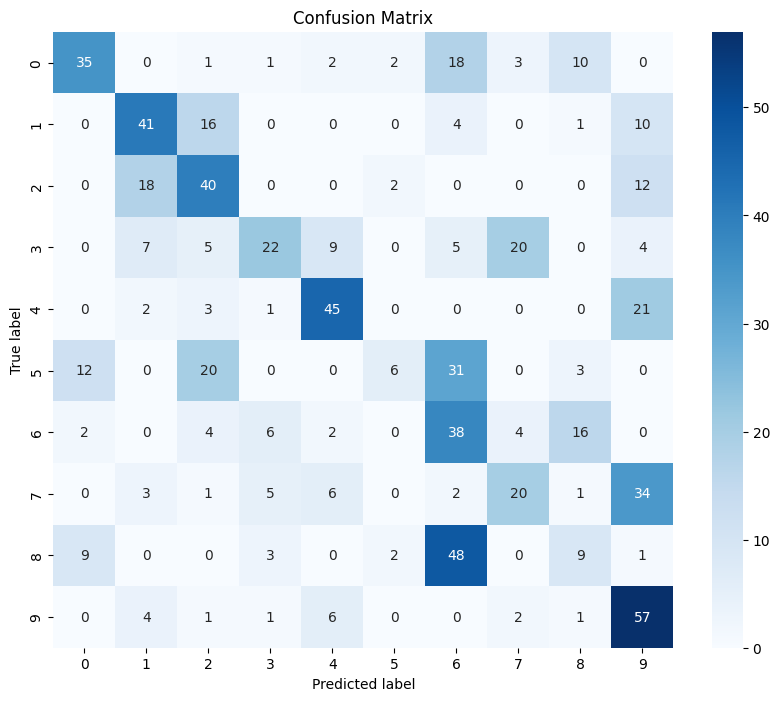

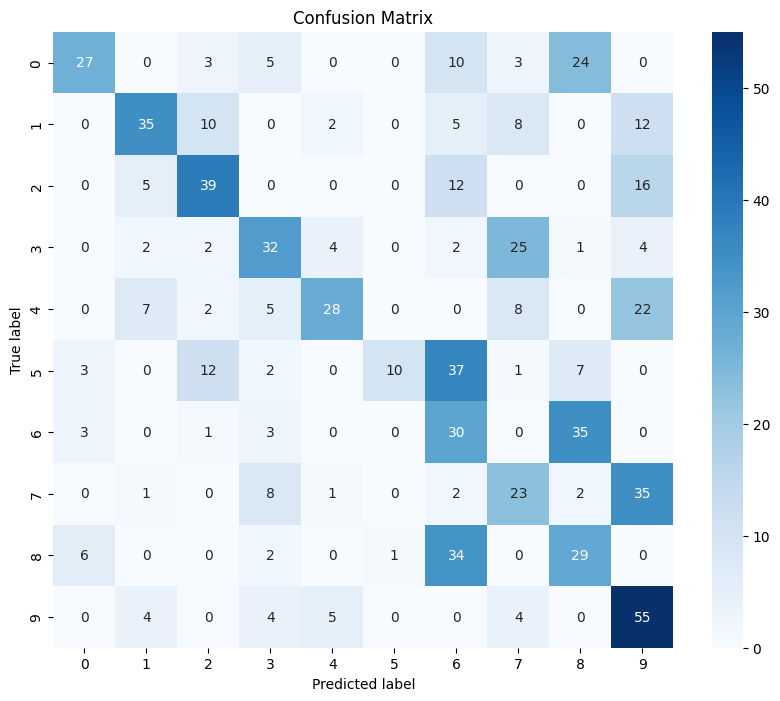

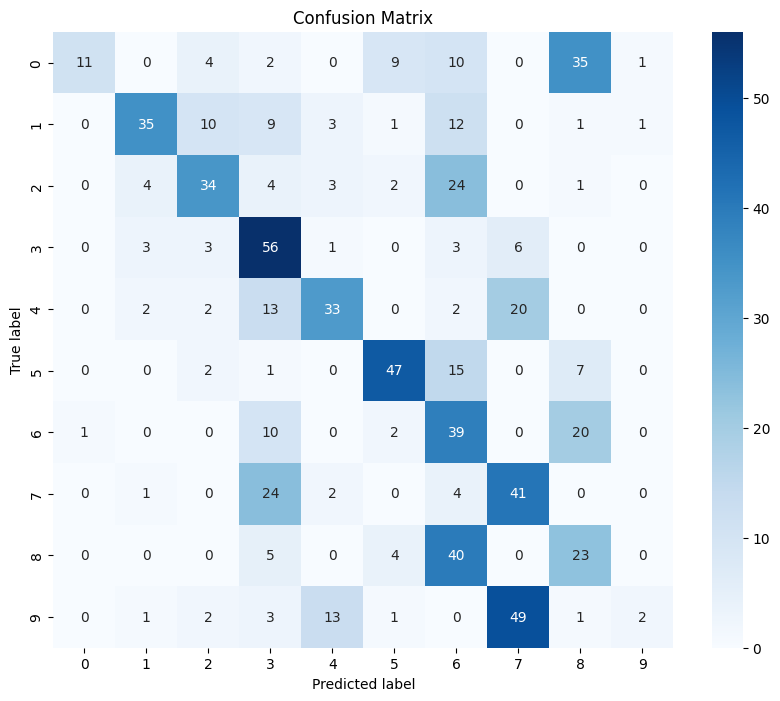

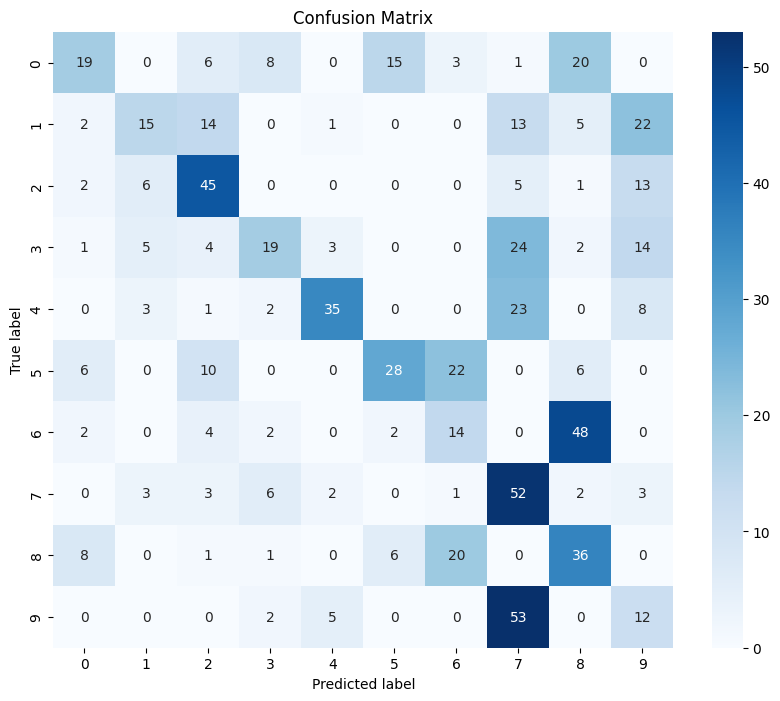

In [ ]:
from itertools import cycle

import wandb
# Initialize Weights & Biases
wandb.login()

config = {
    'num_epochs': 100,
    'k_folds': 5,
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'max_norm': 2.0,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'input_length': 16000,
    'embed_size': 512,
    'num_heads': 1,
    'num_encoder_layers': 3,
    'num_workers':2
}

for fold in range(1, config['k_folds'] + 1):
    if fold == 1:
       continue

    wandb.init(project='audio_classification_assn2', entity='m23csa001',config=config, name=f'NH = 1,Fold {fold}', reinit=True)

    data_module = CustomDataModule(batch_size=config['batch_size'],
                                   num_workers=config['num_workers'],
                                   data_directory=path,
                                   data_frame=df,
                                   validation_fold=fold,
                                   testing_fold=1,
                                   esc_10_flag=True,
                                   file_column='filename',
                                   label_column='category',
                                   sampling_rate=44100,
                                   new_sampling_rate=16000,
                                   sample_length_seconds=1
                                   )

    data_module.setup(stage='fit', current_fold=fold)
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    data_module.setup(stage='test', current_fold=1)
    test_loader = data_module.test_dataloader()

    model_6 = AudioClassifierWithTransformer(num_classes=config['num_classes'], input_length=config['input_length'],
                                             embed_size=config['embed_size'], num_heads=config['num_heads'], num_encoder_layers=config['num_encoder_layers']).to(config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_6.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    for epoch in range(config['num_epochs']):
        train_loss, train_accuracy = train_one_epoch(model_6, train_loader, criterion, optimizer, config['device'], max_norm=config['max_norm'])
        val_loss, val_accuracy = validate_one_epoch(model_6, val_loader, criterion, config['device'])
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == config["num_epochs"]:
           print(f'Fold {fold}, Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
           print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')

    test_loss, test_accuracy, test_f1, test_roc_auc = test_model(model_6, test_loader, criterion, config['device'], config['num_classes'])
    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, ROC AUC: {test_roc_auc:.2f}')
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1': test_f1, 'test_roc_auc': test_roc_auc})

    wandb.finish()


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = total_params - trainable_params

total_params, trainable_params, non_trainable_params

(8877226, 8877226, 0)

###Num head = 2

100%|██████████| 80/80 [00:00<00:00, 16090.94it/s]


Fold 2, Epoch [1/100] - Training Loss: 5.4546, Accuracy: 7.18%
Validation Loss: 3.0370, Accuracy: 10.00%

Fold 2, Epoch [10/100] - Training Loss: 2.0982, Accuracy: 21.62%
Validation Loss: 2.4414, Accuracy: 13.89%

Fold 2, Epoch [20/100] - Training Loss: 1.9964, Accuracy: 22.73%
Validation Loss: 1.8823, Accuracy: 30.00%

Fold 2, Epoch [30/100] - Training Loss: 1.5182, Accuracy: 39.81%
Validation Loss: 1.7051, Accuracy: 36.81%

Fold 2, Epoch [40/100] - Training Loss: 1.2098, Accuracy: 54.26%
Validation Loss: 1.8425, Accuracy: 38.89%

Fold 2, Epoch [50/100] - Training Loss: 1.0162, Accuracy: 61.71%
Validation Loss: 1.7605, Accuracy: 48.06%

Fold 2, Epoch [60/100] - Training Loss: 0.7648, Accuracy: 71.57%
Validation Loss: 2.5268, Accuracy: 32.50%

Fold 2, Epoch [70/100] - Training Loss: 0.9840, Accuracy: 67.45%
Validation Loss: 2.8324, Accuracy: 43.19%

Fold 2, Epoch [80/100] - Training Loss: 0.6673, Accuracy: 78.52%
Validation Loss: 2.3370, Accuracy: 46.67%

Fold 2, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▂▃▂▃▃▃▄▄▅▅▅▆▆▆▅▆▇▆▇▇▇▇▇▇▆▇▇██▇██████
train_loss,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▃▄▃▄▄▄▄▅▅▅▅▆▅▆▅▆▆▅▆▇▆▆▆▆▅▇█▆▇▆█▆▇▇▇█
val_loss,█▄▃▄▃▂▃▂▂▂▂▁▂▂▂▂▄▂▃▁▂▃▄▃▅▄▄▅▅▂▃▄▇▄▃▆▆▅▅▅
test_accuracy,49.86111
test_f1,0.47252
test_loss,2.47568


100%|██████████| 80/80 [00:00<00:00, 12116.58it/s]


Fold 3, Epoch [1/100] - Training Loss: 5.4545, Accuracy: 7.87%
Validation Loss: 3.1127, Accuracy: 10.00%

Fold 3, Epoch [10/100] - Training Loss: 1.8514, Accuracy: 30.19%
Validation Loss: 1.9221, Accuracy: 24.72%

Fold 3, Epoch [20/100] - Training Loss: 1.5895, Accuracy: 36.81%
Validation Loss: 1.6477, Accuracy: 37.92%

Fold 3, Epoch [30/100] - Training Loss: 1.1709, Accuracy: 55.46%
Validation Loss: 1.8022, Accuracy: 41.25%

Fold 3, Epoch [40/100] - Training Loss: 0.8862, Accuracy: 68.61%
Validation Loss: 1.9299, Accuracy: 46.11%

Fold 3, Epoch [50/100] - Training Loss: 0.6269, Accuracy: 78.10%
Validation Loss: 2.2506, Accuracy: 44.86%

Fold 3, Epoch [60/100] - Training Loss: 0.5212, Accuracy: 82.13%
Validation Loss: 2.3246, Accuracy: 50.83%

Fold 3, Epoch [70/100] - Training Loss: 0.4084, Accuracy: 84.35%
Validation Loss: 2.7489, Accuracy: 43.61%

Fold 3, Epoch [80/100] - Training Loss: 0.3835, Accuracy: 84.54%
Validation Loss: 2.6623, Accuracy: 47.50%

Fold 3, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▃▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇████▇█████████▇█
train_loss,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▃▅▅▅▅▆▆▆▇▆█▆█▆▇▇▆██▇▇██▇█▇█▆█▇▇██▇▇█▇
val_loss,▆▄▂▂▁▂▁▃▂▁▂▁▂▁▂▂▃▃▂▃▃▃▄▄▄▄▄▅▆▄▇▄▆▆▄▅█▇▅▅
test_accuracy,42.5
test_f1,0.39674
test_loss,2.96654


100%|██████████| 80/80 [00:00<00:00, 17365.92it/s]


Fold 4, Epoch [1/100] - Training Loss: 4.3727, Accuracy: 13.24%
Validation Loss: 2.9463, Accuracy: 10.00%

Fold 4, Epoch [10/100] - Training Loss: 1.9890, Accuracy: 25.79%
Validation Loss: 2.1329, Accuracy: 24.86%

Fold 4, Epoch [20/100] - Training Loss: 1.6363, Accuracy: 37.82%
Validation Loss: 1.7583, Accuracy: 34.86%

Fold 4, Epoch [30/100] - Training Loss: 1.1934, Accuracy: 53.84%
Validation Loss: 1.6781, Accuracy: 40.56%

Fold 4, Epoch [40/100] - Training Loss: 0.9986, Accuracy: 62.73%
Validation Loss: 2.4607, Accuracy: 30.42%

Fold 4, Epoch [50/100] - Training Loss: 0.8524, Accuracy: 67.50%
Validation Loss: 2.0604, Accuracy: 42.36%

Fold 4, Epoch [60/100] - Training Loss: 0.6456, Accuracy: 77.04%
Validation Loss: 2.2660, Accuracy: 37.64%

Fold 4, Epoch [70/100] - Training Loss: 0.6671, Accuracy: 75.14%
Validation Loss: 2.5866, Accuracy: 44.03%

Fold 4, Epoch [80/100] - Training Loss: 0.6028, Accuracy: 79.07%
Validation Loss: 2.6634, Accuracy: 42.64%

Fold 4, Epoch [90/100] - Trai

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▂▂▃▃▄▄▄▅▅▅▅▆▅▆▆▇▇▇▇▇▇▇▇▇█▇██████████
train_loss,█▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▂▃▂▆▅▄▆▇▆▆▆▇▇▆▆▇▇█▇█▇██▇▇██▇▇▇▇▇▆▇█▇▇▇
val_loss,▇▄▄▂▃▂▂▂▁▁▂▁▂▃▂▃▅▄▄▃▃▃▄▃▄▄▆▆▅█▆▆▇▅█▆▅▅▇▅
test_accuracy,38.88889
test_f1,0.36932
test_loss,2.83455


100%|██████████| 80/80 [00:00<00:00, 16800.74it/s]


Fold 5, Epoch [1/100] - Training Loss: 4.9015, Accuracy: 8.06%
Validation Loss: 2.6006, Accuracy: 10.00%

Fold 5, Epoch [10/100] - Training Loss: 1.9278, Accuracy: 20.97%
Validation Loss: 1.9234, Accuracy: 27.92%

Fold 5, Epoch [20/100] - Training Loss: 1.5916, Accuracy: 38.56%
Validation Loss: 1.5962, Accuracy: 47.78%

Fold 5, Epoch [30/100] - Training Loss: 1.2888, Accuracy: 51.34%
Validation Loss: 1.6349, Accuracy: 50.42%

Fold 5, Epoch [40/100] - Training Loss: 1.2882, Accuracy: 53.52%
Validation Loss: 1.6227, Accuracy: 50.69%

Fold 5, Epoch [50/100] - Training Loss: 0.9875, Accuracy: 63.70%
Validation Loss: 1.8092, Accuracy: 51.11%

Fold 5, Epoch [60/100] - Training Loss: 1.1219, Accuracy: 60.00%
Validation Loss: 1.9407, Accuracy: 48.19%

Fold 5, Epoch [70/100] - Training Loss: 0.9222, Accuracy: 67.64%
Validation Loss: 2.2489, Accuracy: 47.22%

Fold 5, Epoch [80/100] - Training Loss: 0.9493, Accuracy: 65.93%
Validation Loss: 2.4069, Accuracy: 44.72%

Fold 5, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▆▇▆▆▆▆▇▇▇▇▇▇▇▇█▇███
train_loss,█▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▄▅▄▆▆▇▇█▆▇▇▆▇▇▇▇███▇▇▆▇████▇███▇▆▇▇█
val_loss,█▆▃▄▃▃▃▂▂▁▂▁▄▃▂▃▂▃▂▃▂▁▂▃▃▂▃▁▂▂▃▆▅▄▃██▆▆▇
test_accuracy,48.61111
test_f1,0.45347
test_loss,2.40887


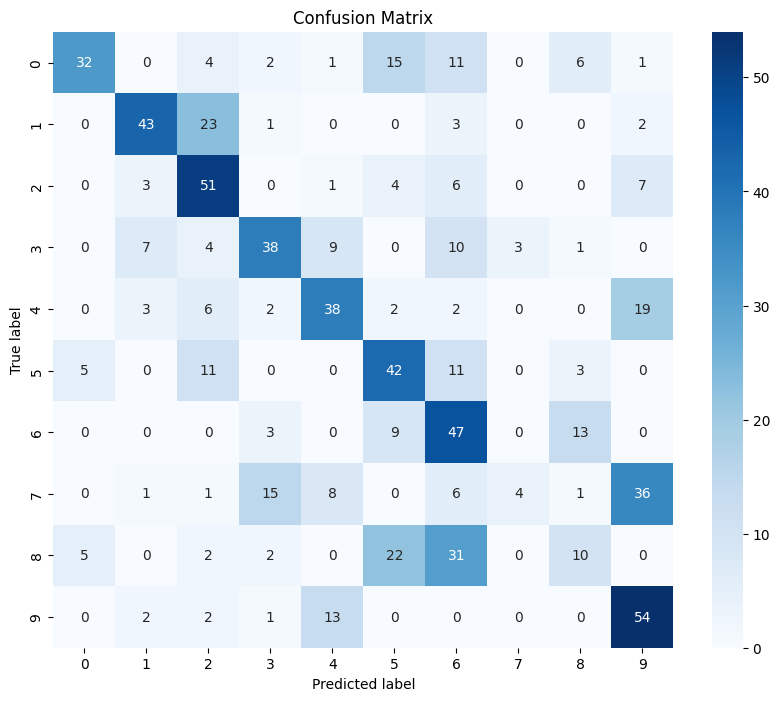

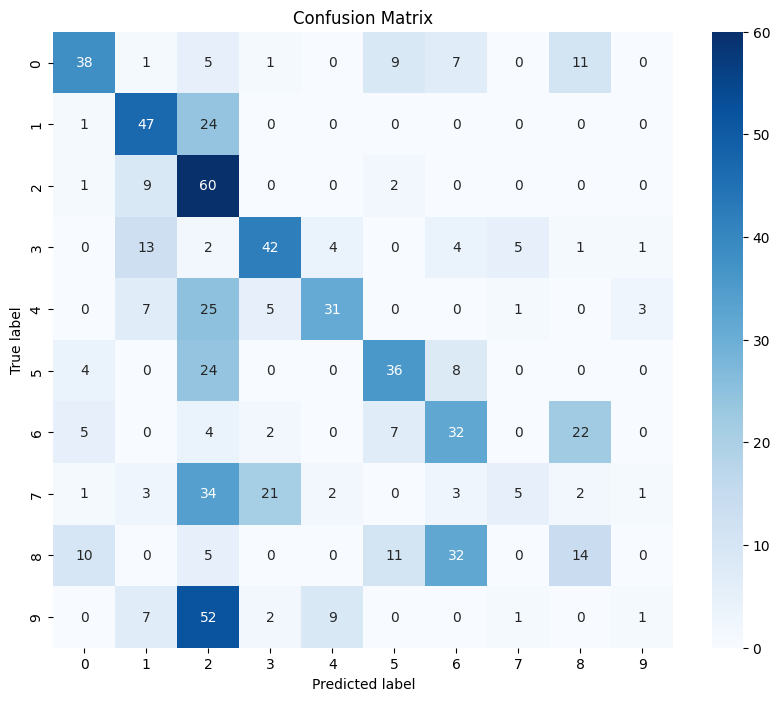

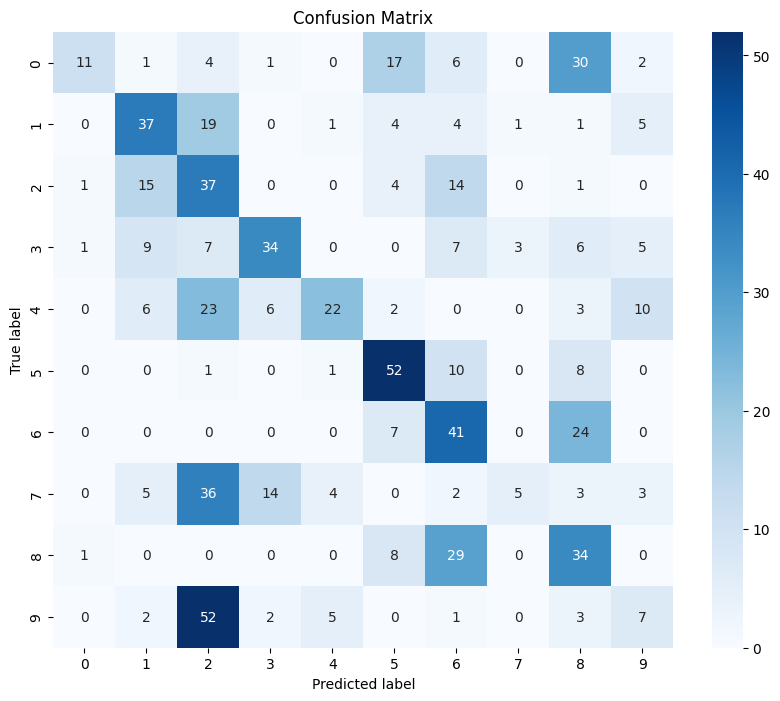

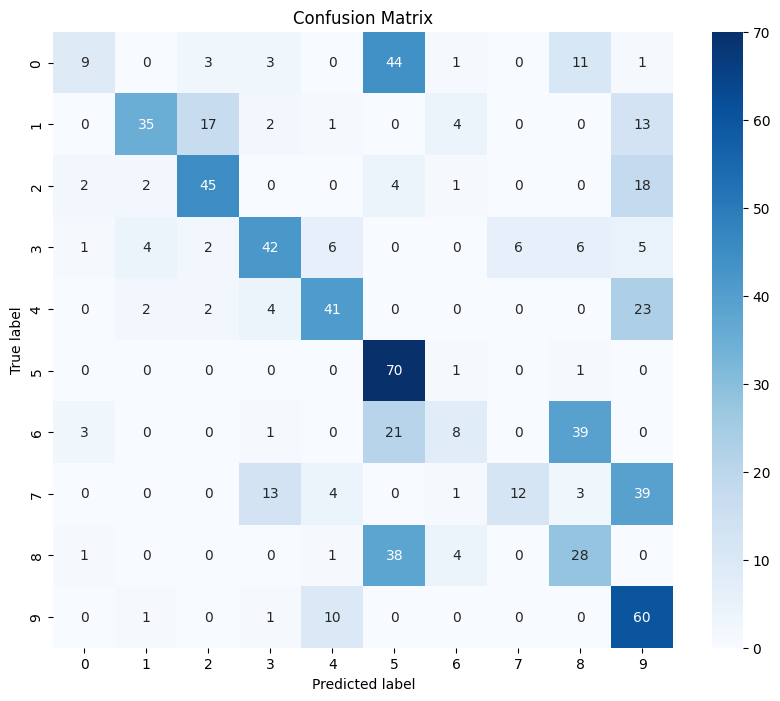

In [ ]:
from itertools import cycle

import wandb
wandb.login()

config = {
    'num_epochs': 100,
    'k_folds': 5,
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'max_norm': 2.0,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'input_length': 16000,
    'embed_size': 512,
    'num_heads': 2,
    'num_encoder_layers': 3,
    'num_workers':2
}

for fold in range(1, config['k_folds'] + 1):
    if fold == 1:
       continue

    wandb.init(project='audio_classification_assn2', entity='m23csa001',config=config, name=f'NH = 1,Fold {fold}', reinit=True)

    data_module = CustomDataModule(batch_size=config['batch_size'],
                                   num_workers=config['num_workers'],
                                   data_directory=path,
                                   data_frame=df,
                                   validation_fold=fold,
                                   testing_fold=1,
                                   esc_10_flag=True,
                                   file_column='filename',
                                   label_column='category',
                                   sampling_rate=44100,
                                   new_sampling_rate=16000,
                                   sample_length_seconds=1
                                   )

    data_module.setup(stage='fit', current_fold=fold)
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    data_module.setup(stage='test', current_fold=1)
    test_loader = data_module.test_dataloader()

    model_5 = AudioClassifierWithTransformer(num_classes=config['num_classes'], input_length=config['input_length'],
                                             embed_size=config['embed_size'], num_heads=config['num_heads'], num_encoder_layers=config['num_encoder_layers']).to(config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_5.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    for epoch in range(config['num_epochs']):
        train_loss, train_accuracy = train_one_epoch(model_5, train_loader, criterion, optimizer, config['device'], max_norm=config['max_norm'])
        val_loss, val_accuracy = validate_one_epoch(model_5, val_loader, criterion, config['device'])
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == config["num_epochs"]:
           print(f'Fold {fold}, Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
           print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')

    test_loss, test_accuracy, test_f1, test_roc_auc = test_model(model_5, test_loader, criterion, config['device'], config['num_classes'])
    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, ROC AUC: {test_roc_auc:.2f}')
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1': test_f1, 'test_roc_auc': test_roc_auc})

    wandb.finish()


###Number of heads = 4

100%|██████████| 80/80 [00:00<00:00, 17705.89it/s]


Fold 2, Epoch [1/100] - Training Loss: 4.6564, Accuracy: 10.09%
Validation Loss: 3.1754, Accuracy: 10.00%

Fold 2, Epoch [10/100] - Training Loss: 1.8805, Accuracy: 23.56%
Validation Loss: 1.9796, Accuracy: 20.42%

Fold 2, Epoch [20/100] - Training Loss: 1.4719, Accuracy: 46.94%
Validation Loss: 1.6218, Accuracy: 39.86%

Fold 2, Epoch [30/100] - Training Loss: 1.3002, Accuracy: 49.72%
Validation Loss: 1.5409, Accuracy: 46.53%

Fold 2, Epoch [40/100] - Training Loss: 1.6323, Accuracy: 43.61%
Validation Loss: 1.9580, Accuracy: 30.83%

Fold 2, Epoch [50/100] - Training Loss: 1.1639, Accuracy: 57.45%
Validation Loss: 1.4204, Accuracy: 42.22%

Fold 2, Epoch [60/100] - Training Loss: 1.2756, Accuracy: 52.41%
Validation Loss: 1.6254, Accuracy: 42.08%

Fold 2, Epoch [70/100] - Training Loss: 0.9942, Accuracy: 61.20%
Validation Loss: 1.7315, Accuracy: 38.75%

Fold 2, Epoch [80/100] - Training Loss: 1.3840, Accuracy: 51.81%
Validation Loss: 1.9325, Accuracy: 42.50%

Fold 2, Epoch [90/100] - Trai

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▄▄▅▅▆▆▆▆▅▇▆▆▆▅▇▇▆▆▅▆▇███▇▇▆▆▇▇▇▇▆▅▅
train_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▁▁▁▁▂▁▂▂▁▁▁▁▂▂▂
val_accuracy,▁▁▂▃▄▇▇▆▆▆▅▇██▇▇▆▆▆█▇█▇▆▆▇▇█▆▇█▇▇█▇▆█▆▄▆
val_loss,█▄▇▄▃▂▁▂▃▂▃▂▂▁▂▂▂▂▂▁▃▁▁▃▂▂▁▂▃▂▂▃▂▂▃▂▂▄▅▂
test_accuracy,39.58333
test_f1,0.3486
test_loss,1.45062


100%|██████████| 80/80 [00:00<00:00, 16768.83it/s]


Fold 3, Epoch [1/100] - Training Loss: 5.3555, Accuracy: 7.96%
Validation Loss: 3.1152, Accuracy: 10.00%

Fold 3, Epoch [10/100] - Training Loss: 2.0352, Accuracy: 20.05%
Validation Loss: 2.6311, Accuracy: 24.03%

Fold 3, Epoch [20/100] - Training Loss: 1.6263, Accuracy: 38.47%
Validation Loss: 1.5909, Accuracy: 40.14%

Fold 3, Epoch [30/100] - Training Loss: 1.5143, Accuracy: 44.91%
Validation Loss: 1.6159, Accuracy: 40.69%

Fold 3, Epoch [40/100] - Training Loss: 1.2735, Accuracy: 50.79%
Validation Loss: 1.8954, Accuracy: 34.72%

Fold 3, Epoch [50/100] - Training Loss: 1.3852, Accuracy: 46.20%
Validation Loss: 1.4538, Accuracy: 47.22%

Fold 3, Epoch [60/100] - Training Loss: 1.0267, Accuracy: 62.36%
Validation Loss: 1.5453, Accuracy: 48.06%

Fold 3, Epoch [70/100] - Training Loss: 1.1815, Accuracy: 55.05%
Validation Loss: 1.6980, Accuracy: 43.75%

Fold 3, Epoch [80/100] - Training Loss: 0.9502, Accuracy: 67.08%
Validation Loss: 1.7269, Accuracy: 46.94%

Fold 3, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▂▂▂▃▃▄▄▅▅▅▅▅▅▆▆▅▅▅▅▆▆▆▇▇▇▇▇▇█▇▇▇▇▇██▇██
train_loss,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▃▄▄▅▆▆▅▇▄▆▇▇▆▆▆▇▆▇▇▇█▆▇▇▆▆▆▇▇▆▇▇▆▇▃▇▆
val_loss,▄▃▃▂▂▂▂▂▁▂▁▃▁▁▁▁▂▂▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▂█▂▃
test_accuracy,36.52778
test_f1,0.33851
test_loss,2.25571


100%|██████████| 80/80 [00:00<00:00, 17621.28it/s]


Fold 4, Epoch [1/100] - Training Loss: 4.3782, Accuracy: 8.15%
Validation Loss: 2.6747, Accuracy: 10.00%

Fold 4, Epoch [10/100] - Training Loss: 1.7710, Accuracy: 26.30%
Validation Loss: 1.7371, Accuracy: 34.17%

Fold 4, Epoch [20/100] - Training Loss: 1.4719, Accuracy: 46.11%
Validation Loss: 1.8461, Accuracy: 30.28%

Fold 4, Epoch [30/100] - Training Loss: 1.4229, Accuracy: 48.10%
Validation Loss: 1.7092, Accuracy: 36.67%

Fold 4, Epoch [40/100] - Training Loss: 1.2479, Accuracy: 53.94%
Validation Loss: 1.6709, Accuracy: 41.53%

Fold 4, Epoch [50/100] - Training Loss: 1.2498, Accuracy: 53.47%
Validation Loss: 1.7610, Accuracy: 38.19%

Fold 4, Epoch [60/100] - Training Loss: 1.2441, Accuracy: 54.58%
Validation Loss: 1.6717, Accuracy: 42.36%

Fold 4, Epoch [70/100] - Training Loss: 1.1149, Accuracy: 57.87%
Validation Loss: 1.7361, Accuracy: 43.47%

Fold 4, Epoch [80/100] - Training Loss: 0.9899, Accuracy: 63.94%
Validation Loss: 1.5972, Accuracy: 51.39%

Fold 4, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▂▃▃▄▄▄▄▅▅▄▄▅▅▅▅▅▅▅▅▅▅▆▄▅▆▅▅▅▆▆▆▇▇▇▇▇▇██
train_loss,█▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▃▂▂▂▄▂▂▂▂▂▂▁▁▁▁▁
val_accuracy,▁▃▃▄▄▅▇▅▅▆▆▅▅▆▅▅▇▆▆▅▆▆▆▆▆▇▅▇▆▆▆▅▇▆███▇██
val_loss,█▆▃▂▃▂▁▃▂▁▂▂▂▂▃▃▂▃▁▂▃▂▃▂▃▂▃▂▂▃▃▄▃▃▂▂▁▁▃▃
test_accuracy,45.13889
test_f1,0.43864
test_loss,2.08038


100%|██████████| 80/80 [00:00<00:00, 7182.64it/s]


Fold 5, Epoch [1/100] - Training Loss: 4.5537, Accuracy: 9.68%
Validation Loss: 2.9283, Accuracy: 10.00%

Fold 5, Epoch [10/100] - Training Loss: 2.1031, Accuracy: 16.44%
Validation Loss: 2.0842, Accuracy: 20.28%

Fold 5, Epoch [20/100] - Training Loss: 1.7169, Accuracy: 32.45%
Validation Loss: 2.0421, Accuracy: 29.58%

Fold 5, Epoch [30/100] - Training Loss: 1.4755, Accuracy: 43.84%
Validation Loss: 1.8670, Accuracy: 37.78%

Fold 5, Epoch [40/100] - Training Loss: 1.3363, Accuracy: 50.05%
Validation Loss: 1.9255, Accuracy: 40.00%

Fold 5, Epoch [50/100] - Training Loss: 1.2177, Accuracy: 54.95%
Validation Loss: 1.8552, Accuracy: 48.33%

Fold 5, Epoch [60/100] - Training Loss: 1.1019, Accuracy: 62.27%
Validation Loss: 1.9794, Accuracy: 49.44%

Fold 5, Epoch [70/100] - Training Loss: 0.8529, Accuracy: 69.12%
Validation Loss: 2.6153, Accuracy: 45.28%

Fold 5, Epoch [80/100] - Training Loss: 0.6848, Accuracy: 75.65%
Validation Loss: 2.5547, Accuracy: 45.14%

Fold 5, Epoch [90/100] - Train

test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▂▂▂▃▃▄▄▄▄▅▃▅▅▄▅▅▆▆▆▆▇▆▇▇▇▇▇▇█▇██████
train_loss,█▄▃▄▄▃▃▃▃▃▃▃▃▂▇▂▂▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁
val_accuracy,▁▃▃▁▄▅▅▄▆▆▇▆▆▇▆▇▆▇▇▇▇▇▇█▆▇▇▆█▇▆█▇▆█▇▇▇▇█
val_loss,▆▃▂▃▂▂▂▂▂▃▂▁▂▂▄▁▃▁▂▂▂▃▃▃▃▂▃▄▄▃▅▄▆█▃▇▆▆▇▅
test_accuracy,42.77778
test_f1,0.40429
test_loss,2.48945


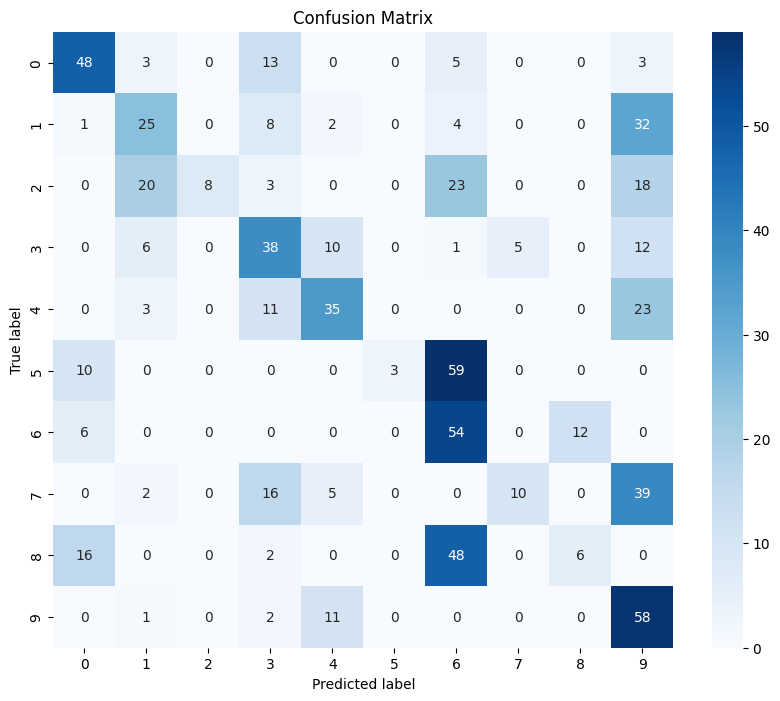

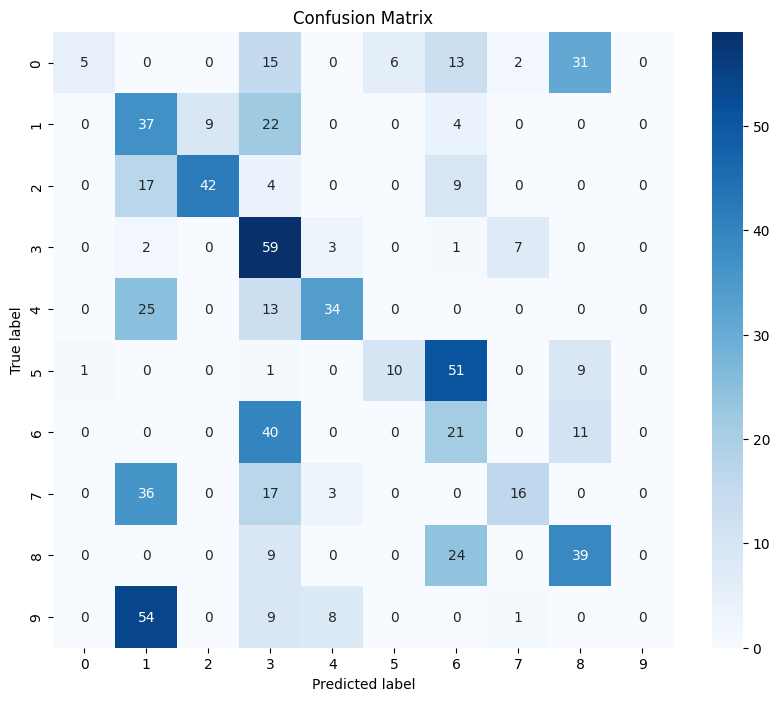

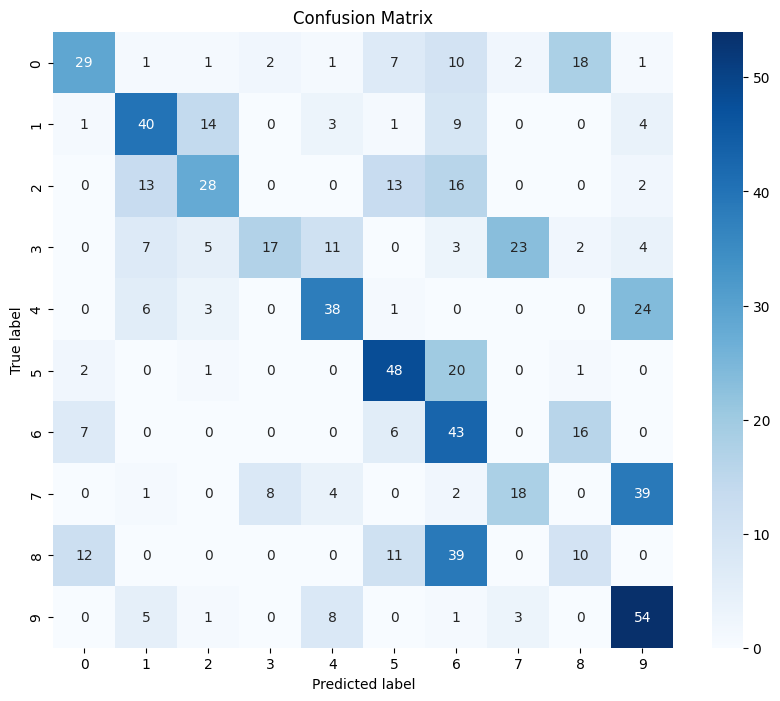

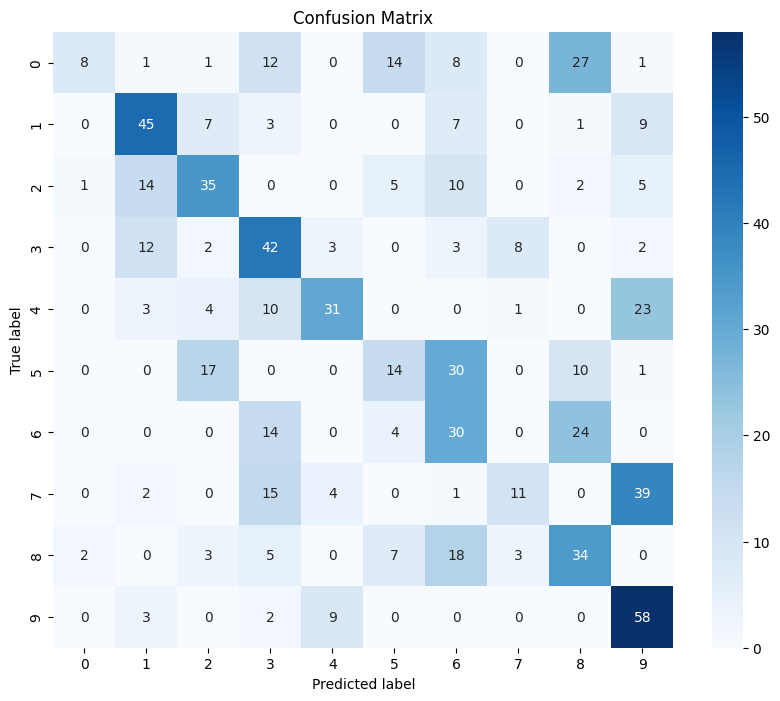

In [ ]:
from itertools import cycle

import wandb
wandb.login()

config = {
    'num_epochs': 100,
    'k_folds': 5,
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'max_norm': 2.0,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'input_length': 16000,
    'embed_size': 512,
    'num_heads': 4,
    'num_encoder_layers': 3,
    'num_workers':2
}

for fold in range(1, config['k_folds'] + 1):
    if fold == 1:
       continue

    wandb.init(project='audio_classification_assn2', entity='m23csa001',config=config, name=f'NH = 1,Fold {fold}', reinit=True)

    data_module = CustomDataModule(batch_size=config['batch_size'],
                                   num_workers=config['num_workers'],
                                   data_directory=path,
                                   data_frame=df,
                                   validation_fold=fold,
                                   testing_fold=1,
                                   esc_10_flag=True,
                                   file_column='filename',
                                   label_column='category',
                                   sampling_rate=44100,
                                   new_sampling_rate=16000,
                                   sample_length_seconds=1
                                   )
    data_module.setup(stage='fit', current_fold=fold)
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    data_module.setup(stage='test', current_fold=1)
    test_loader = data_module.test_dataloader()

    model_7 = AudioClassifierWithTransformer(num_classes=config['num_classes'], input_length=config['input_length'],
                                             embed_size=config['embed_size'], num_heads=config['num_heads'], num_encoder_layers=config['num_encoder_layers']).to(config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_7.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

    for epoch in range(config['num_epochs']):
        train_loss, train_accuracy = train_one_epoch(model_7, train_loader, criterion, optimizer, config['device'], max_norm=config['max_norm'])
        val_loss, val_accuracy = validate_one_epoch(model_7, val_loader, criterion, config['device'])
        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy})

        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == config["num_epochs"]:
           print(f'Fold {fold}, Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
           print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')

    test_loss, test_accuracy, test_f1, test_roc_auc = test_model(model_7, test_loader, criterion, config['device'], config['num_classes'])
    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, ROC AUC: {test_roc_auc:.2f}')
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1': test_f1, 'test_roc_auc': test_roc_auc})

    wandb.finish()


###Hyperparameters Tuning

####Max norm = 1.5 , learning rate scheduler and optimizer as AdamW

100%|██████████| 80/80 [00:00<00:00, 14394.25it/s]


Fold 2, Epoch [1/100] - Training Loss: 4.7760, Accuracy: 12.04%
Validation Loss: 2.7034, Accuracy: 10.00%

Fold 2, Epoch [10/100] - Training Loss: 1.8697, Accuracy: 25.42%
Validation Loss: 1.8638, Accuracy: 27.08%

Fold 2, Epoch [20/100] - Training Loss: 1.9673, Accuracy: 35.32%
Validation Loss: 1.6723, Accuracy: 36.11%

Epoch 00026: reducing learning rate of group 0 to 1.0000e-04.
Fold 2, Epoch [30/100] - Training Loss: 1.2158, Accuracy: 55.28%
Validation Loss: 1.4921, Accuracy: 43.33%

Fold 2, Epoch [40/100] - Training Loss: 1.0490, Accuracy: 62.27%
Validation Loss: 1.5044, Accuracy: 43.47%

Epoch 00042: reducing learning rate of group 0 to 1.0000e-05.
Fold 2, Epoch [50/100] - Training Loss: 0.9784, Accuracy: 65.19%
Validation Loss: 1.5234, Accuracy: 44.44%

Epoch 00053: reducing learning rate of group 0 to 1.0000e-06.
Fold 2, Epoch [60/100] - Training Loss: 0.9788, Accuracy: 65.23%
Validation Loss: 1.5249, Accuracy: 45.28%

Epoch 00064: reducing learning rate of group 0 to 1.0000e-0

lr,██████████▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▄▄▂▄▅▅▆▇▇▇▇▇███████████████████████
train_loss,█▄▃▃▃▂▂▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▆▇▄▅▇▇█▇█▇████████████████████████
val_loss,█▆▄▄▃▃▃▂▃▃▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0
test_accuracy,51.11111


100%|██████████| 80/80 [00:00<00:00, 14952.29it/s]


Fold 3, Epoch [1/100] - Training Loss: 4.0850, Accuracy: 8.10%
Validation Loss: 3.2268, Accuracy: 8.19%

Fold 3, Epoch [10/100] - Training Loss: 1.8428, Accuracy: 28.98%
Validation Loss: 1.7592, Accuracy: 27.78%

Fold 3, Epoch [20/100] - Training Loss: 1.5563, Accuracy: 40.60%
Validation Loss: 1.7006, Accuracy: 39.03%

Fold 3, Epoch [30/100] - Training Loss: 1.3249, Accuracy: 45.65%
Validation Loss: 1.5613, Accuracy: 43.75%

Fold 3, Epoch [40/100] - Training Loss: 1.2183, Accuracy: 54.91%
Validation Loss: 1.8106, Accuracy: 43.75%

Epoch 00048: reducing learning rate of group 0 to 1.0000e-04.
Fold 3, Epoch [50/100] - Training Loss: 0.9136, Accuracy: 68.01%
Validation Loss: 1.4636, Accuracy: 53.19%

Epoch 00059: reducing learning rate of group 0 to 1.0000e-05.
Fold 3, Epoch [60/100] - Training Loss: 0.6464, Accuracy: 77.27%
Validation Loss: 1.5073, Accuracy: 54.31%

Epoch 00070: reducing learning rate of group 0 to 1.0000e-06.
Fold 3, Epoch [70/100] - Training Loss: 0.6156, Accuracy: 79.

lr,███████████████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▇▆▆▇▇▇█████████████████
train_loss,█▅▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▄▄▅▅▅▅▆▅▆▇▇▆▇▆▇▅▇▇▇██████████████████
val_loss,█▄▄▃▃▂▂▂▂▂▂▁▁▂▁▂▂▂▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0
test_accuracy,58.19444


100%|██████████| 80/80 [00:00<00:00, 15420.94it/s]


Fold 4, Epoch [1/100] - Training Loss: 4.2791, Accuracy: 10.56%
Validation Loss: 3.2124, Accuracy: 10.00%

Fold 4, Epoch [10/100] - Training Loss: 1.7280, Accuracy: 31.71%
Validation Loss: 1.7769, Accuracy: 31.39%

Fold 4, Epoch [20/100] - Training Loss: 1.5356, Accuracy: 39.49%
Validation Loss: 1.8675, Accuracy: 30.69%

Fold 4, Epoch [30/100] - Training Loss: 1.5183, Accuracy: 43.52%
Validation Loss: 1.4999, Accuracy: 39.31%

Fold 4, Epoch [40/100] - Training Loss: 1.2596, Accuracy: 51.44%
Validation Loss: 1.6745, Accuracy: 38.61%

Epoch 00044: reducing learning rate of group 0 to 1.0000e-04.
Fold 4, Epoch [50/100] - Training Loss: 0.7425, Accuracy: 73.75%
Validation Loss: 1.4342, Accuracy: 53.61%

Epoch 00058: reducing learning rate of group 0 to 1.0000e-05.
Fold 4, Epoch [60/100] - Training Loss: 0.5955, Accuracy: 79.44%
Validation Loss: 1.5878, Accuracy: 51.67%

Epoch 00069: reducing learning rate of group 0 to 1.0000e-06.
Fold 4, Epoch [70/100] - Training Loss: 0.5610, Accuracy: 8

lr,█████████████████▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▂▃▃▃▃▄▄▄▃▄▅▅▅▅▅▆▇▇▇▇██████████████████
train_loss,█▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▃▅▅▅▄▅▅▅▇▆▆▇▆█████▇████████████████
val_loss,█▄▃▃▂▃▃▂▂▄▂▁▃▁▂▃▂▂▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
lr,0.0
test_accuracy,50.27778


100%|██████████| 80/80 [00:00<00:00, 16738.72it/s]


Fold 5, Epoch [1/100] - Training Loss: 4.9147, Accuracy: 9.26%
Validation Loss: 2.9674, Accuracy: 10.00%

Fold 5, Epoch [10/100] - Training Loss: 1.8727, Accuracy: 25.42%
Validation Loss: 1.8415, Accuracy: 35.69%

Fold 5, Epoch [20/100] - Training Loss: 1.5986, Accuracy: 40.65%
Validation Loss: 1.7959, Accuracy: 35.28%

Fold 5, Epoch [30/100] - Training Loss: 1.3123, Accuracy: 49.54%
Validation Loss: 1.6398, Accuracy: 46.67%

Fold 5, Epoch [40/100] - Training Loss: 1.1293, Accuracy: 60.14%
Validation Loss: 1.7099, Accuracy: 48.19%

Epoch 00050: reducing learning rate of group 0 to 1.0000e-04.
Fold 5, Epoch [50/100] - Training Loss: 0.8426, Accuracy: 68.56%
Validation Loss: 1.9896, Accuracy: 51.94%

Fold 5, Epoch [60/100] - Training Loss: 0.4067, Accuracy: 85.88%
Validation Loss: 2.2454, Accuracy: 53.89%

Epoch 00061: reducing learning rate of group 0 to 1.0000e-05.
Fold 5, Epoch [70/100] - Training Loss: 0.3660, Accuracy: 87.45%
Validation Loss: 2.3431, Accuracy: 54.03%

Epoch 00072: r

lr,████████████████████▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁
test_f1,▁
test_loss,▁
test_roc_auc,▁
train_accuracy,▁▁▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇███████████████████
train_loss,█▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▅▄▄▄▅▅▆▅▆▆▆█▆▇▇▆████████████████████
val_loss,█▇▄▃▃▃▂▂▂▃▂▂▂▂▂▁▂▃▂▃▃▃▄▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
lr,0.0
test_accuracy,51.11111


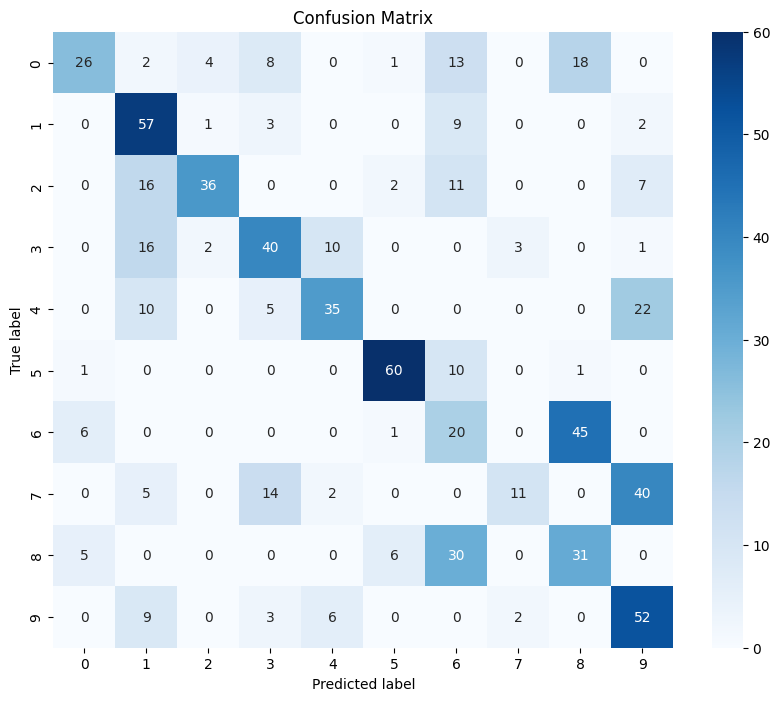

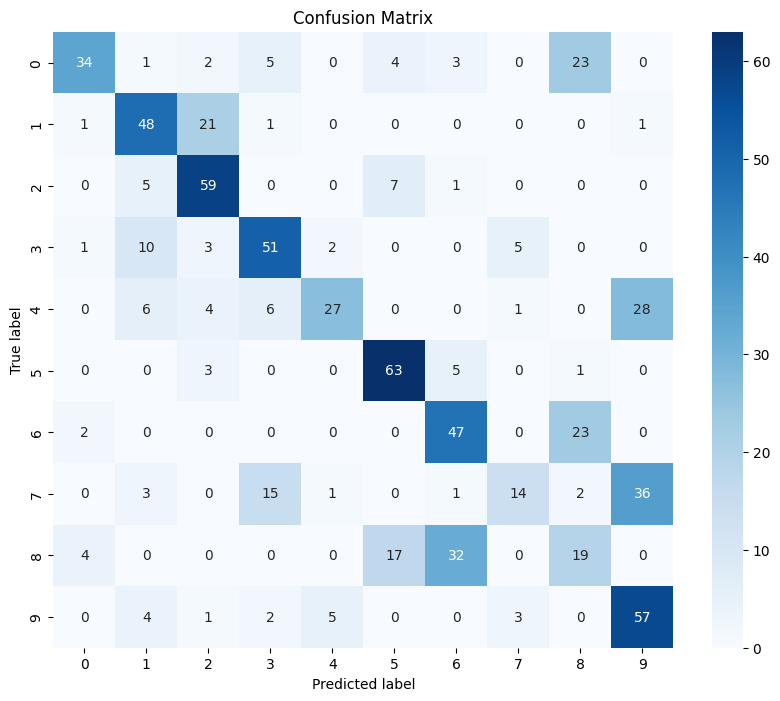

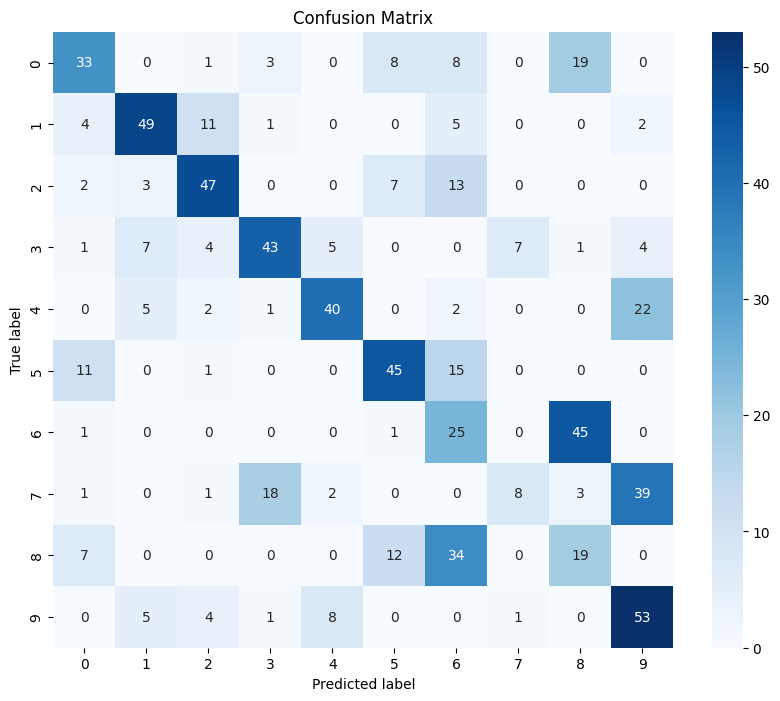

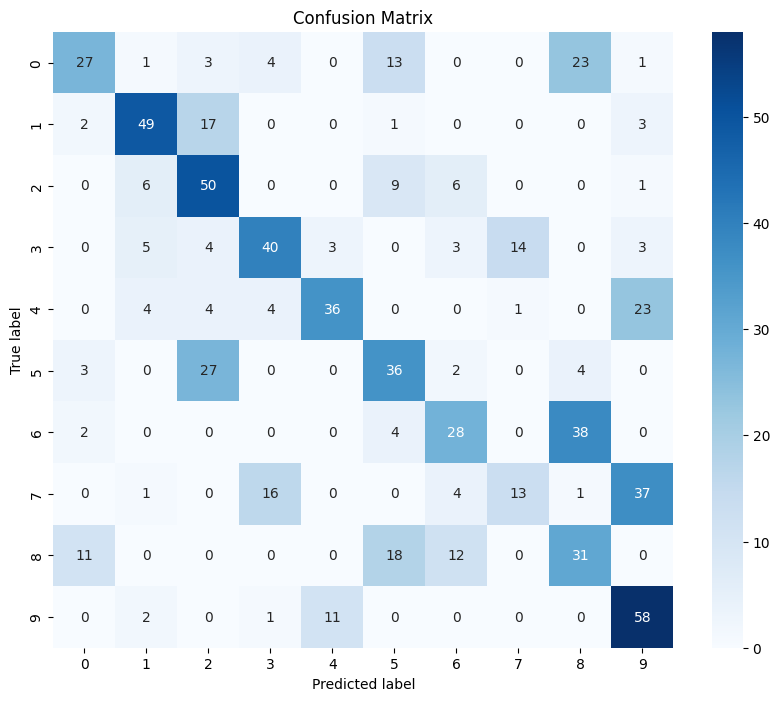

In [ ]:
from itertools import cycle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb

wandb.login()

config = {
    'num_epochs': 100,
    'k_folds': 5,
    'num_classes': 10,
    'batch_size': 32,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,
    'max_norm': 1.5,  # Updated max_norm
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu"),
    'input_length': 16000,
    'embed_size': 512,
    'num_heads': 4,
    'num_encoder_layers': 3,
    'num_workers': 2
}

for fold in range(1, config['k_folds'] + 1):
    if fold == 1:
        continue

    wandb.init(project='audio_classification_assn2', entity='m23csa001', config=config, name=f'NH = 1, Fold {fold}', reinit=True)

    data_module = CustomDataModule(batch_size=config['batch_size'],
                                   num_workers=config['num_workers'],
                                   data_directory=path,
                                   data_frame=df,
                                   validation_fold=fold,
                                   testing_fold=1,
                                   esc_10_flag=True,
                                   file_column='filename',
                                   label_column='category',
                                   sampling_rate=44100,
                                   new_sampling_rate=16000,
                                   sample_length_seconds=1
                                   )
    data_module.setup(stage='fit', current_fold=fold)
    train_loader = data_module.train_dataloader()
    val_loader = data_module.val_dataloader()

    data_module.setup(stage='test', current_fold=1)
    test_loader = data_module.test_dataloader()

    model_8 = AudioClassifierWithTransformer(num_classes=config['num_classes'], input_length=config['input_length'],
                                             embed_size=config['embed_size'], num_heads=config['num_heads'], num_encoder_layers=config['num_encoder_layers']).to(config['device'])

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model_8.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])  # Changed to AdamW

    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.1, verbose=True)

    for epoch in range(config['num_epochs']):
        train_loss, train_accuracy = train_one_epoch(model_8, train_loader, criterion, optimizer, config['device'], max_norm=config['max_norm'])
        val_loss, val_accuracy = validate_one_epoch(model_8, val_loader, criterion, config['device'])

        scheduler.step(val_loss)

        wandb.log({'train_loss': train_loss, 'train_accuracy': train_accuracy, 'val_loss': val_loss, 'val_accuracy': val_accuracy, 'lr': optimizer.param_groups[0]['lr']})

        if epoch == 0 or (epoch + 1) % 10 == 0 or (epoch + 1) == config["num_epochs"]:
            print(f'Fold {fold}, Epoch [{epoch+1}/{config["num_epochs"]}] - Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%\n')


    test_loss, test_accuracy, test_f1, test_roc_auc = test_model(model_8, test_loader, criterion, config['device'], config['num_classes'])
    print(f'Fold {fold}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, F1 Score: {test_f1:.2f}, ROC AUC: {test_roc_auc:.2f}')
    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy, 'test_f1': test_f1, 'test_roc_auc': test_roc_auc})

    wandb.finish()
